# Tech Connect Session - Inventory Manager Solution

## Requirements

* Azure Subscription with Reader access 
* Azure AI Search, Basic tier or higher
* Azure AI Service multiservice account  
* Azure OpenAI  
  * Models: 
    * 'text-embedding-3-large'
    * 'GPT-4o'
* Python environment, version 3.10 or higher
* GitHub CodeSpaces
* Visual Studio Code
  * Extensions: Python and Jupyper

In [1]:
# Python packages
# ! pip install -r requirements.txt

In [28]:
# Libraries
import os
from dotenv import load_dotenv

# Import Utility Functions
from utils import (
    display_image,
    word_wrap,
    local_image_to_data_url
)

# Azure Python libraries
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes.models import (    
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField,
    SemanticSearch
)
from azure.search.documents import SearchClient
from azure.search.documents.models import (
    VectorizableTextQuery,
    VectorizableImageBinaryQuery,
    VectorizableImageUrlQuery
)

# OpenAI Python libraries
from openai import AzureOpenAI

In [29]:
#load variables
load_dotenv()

# Variables - Azure Services
AZURE_SEARCH_SERVICE=os.environ["AZURE_SEARCH_SERVICE"]
AZURE_SEARCH_KEY=os.environ["AZURE_SEARCH_KEY"]
AZURE_OPENAI_ACCOUNT=os.environ["AZURE_OPENAI_ACCOUNT"]
AZURE_OPENAI_KEY=os.environ["AZURE_OPENAI_KEY"]

# Variables - Names
azure_openai_embedding="text-embedding-3-large"
azure_openai_gpt4o_name="gpt-4o"
vision_model_version="2023-04-15"
azureai_index_name="index-tc-iims-v3"

## Laboratory

### Configure the search semantic configuration

In [30]:
semantic_config_name="semantic-config-iims-v3"

# New semantic configuration
# Python SemanticConfiguration Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.semanticconfiguration?view=azure-python
semantic_config=SemanticConfiguration(
    name=semantic_config_name,
    # Python SemanticPrioritizedFields Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.semanticprioritizedfields?view=azure-python
    prioritized_fields=SemanticPrioritizedFields(
        title_field=SemanticField(field_name="title"),        
        content_fields=[SemanticField(field_name="chunk")]
    )
)

# Create the semantic settings with the configuration
semantic_search=SemanticSearch(configurations=[semantic_config])

### Run a query in Azure AI Search

The objectives of this section are: 
* Send a query to confirm your index is operational. 
*  This request converts the text string "what's NASA's website?" into a vector for a vector search using the VectorizableTextQuery Class. 
* Results consist of the fields in the select statement, some of which are printed as output.

In [31]:
# from azure.search.documents import SearchClient
# from azure.search.documents.models import VectorizableTextQuery

# Vector Search using text-to-vector conversion of the querystring

# Python SearchClient Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.searchclient?view=azure-python
search_client=SearchClient(
    endpoint=AZURE_SEARCH_SERVICE, 
    credential=AzureKeyCredential(AZURE_SEARCH_KEY), 
    index_name=azureai_index_name
)

#### [Keyword Search (Simple Search and Full Text Query)](https://learn.microsoft.com/en-us/azure/search/search-query-create?tabs=sdk-text-query)

* **Simple Search:** the default simple query parser is optimal for full text search. 
* **Full Text Query:** the full Lucene query parser is for advanced query constructs like regular expressions, proximity search, fuzzy and wildcard search.

Result 1:
  Score: 4.575854
  Source Document: health-supplement-vitamins-newage-1.jpg
  Chunk: 2 pack NEW AGE NEW AGE IMMUNE SUPPORT IMMUNE SUPPORT 8- IN -1 8- IN -1 VITAMIN C ECHINACEA VITAMIN C ECHINACEA GINGER TURMERIC GINGER TURMERIC ELDERBERRY VITAMIN B6 ELDERBERRY VITAMIN VITAMIN D3 ZINC VITAMIN D3 ZIN 60 CAPSULES 60 CAPSULES DIETARY SUPPLEMENT DIETARY SUPPLE


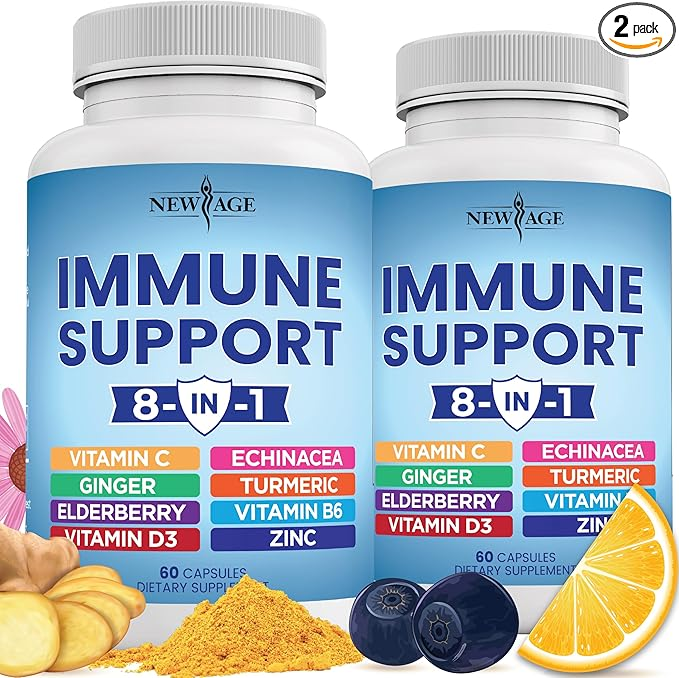

---------------------------
Result 2:
  Score: 2.8759694
  Source Document: health-supplement-vitamins-muscletech-1.jpg
  Chunk: MUSCLETECH PLATINUM OVER 100% MULTI DAILY VALUE OF VITAMIN C&E VITAMIN ENZYMES & MINERALS DAILY NUTRITIONAL IMMUNE SUPPORT FOR ACTIVE SUPPORT INDIVIDUALS FROM VITAMIN C & ZINC1,4 18 816MG 401MG VITAMINS & MINERALS AMINO HERBAL SUPPORT MATRIX+ 90 TABLETS #Per Serving DIETARY SUPPLEMENT
---------------------------
Result 3:
  Score: 2.7574742
  Source Document: health-supplement-vitaminc-emergenc-1.jpg
  Chunk: Naturally, It's Good for You Emergen.C 24 Nutrients 7 B Vitamins 1,000 MG Electrolytes Vitamin C DIETARY SUPPLEMENT Super Orange Antioxidants Flavored Fizzy Drink Mix 30 PACKETS . NET WT. 9.3 OZ (264 g)
---------------------------
Result 4:
  Score: 1.8061415
  Source Document: health-supplement-vitamind-naturesbounty-1.jpg
  Chunk: NATURE'S BOUNTY S D3 50 mcg (2000IU) Supports Strong Bones & Immune Health* IMMUNE HEALTH 240 Rapid Release Softgels VITAMI

In [32]:
# Query Type: Simple
query="Vitamin C"

# Run a simple query
results=search_client.search(  
    query_type='simple',
    search_text=query, 
    top=5
)  

n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    print(f"  Chunk: {result['chunk']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 300, 300)
    print("---------------------------")
    n += 1

Result 1:
  Score: 2.0
  Source Document: health-supplement-preworkout-c4sport-1.jpg
  Chunk: C4 SPORT #1 GLOBAL PREWORKOUT BRAND' ON THE FIELD OR IN THE GYM, THIS NSF® CERTIFIED PRE-WORKOUT HELPS FUEL YOUR PERFORMANCE AND HYDRATION* SUPPLEMENT FACTS ELEVATED Serving Size: 7.1g (Approx. 1 scoop) ENERGY Servings Per Container: 30 Amount Per Serving %DV Fuel your fitness journey with the Calories 5 energy boost from 135mg of Caffeine* Total Carbohydrate 1g <1% ** Total Sugars 0g MUSCULAR Vitamin B6 (as Pyridoxine HCI) 3.4mg 200% ENDURANCE =* A Vitamin B12 (as Cyanocobalamin) 60mcg 2500% Calcium 25mg 2% Power through trainings with CarnoSyno Magnesium (as Magnesium Chloride) 12mc 3% Beta-Alanine, which helps support muscular Sodium (as Sodium Citrate) 60mg 3% endurance and combat muscular fatigue*^ Potassium (as Dipotassium Phosphate) 20mg <1% SUPPORTS C4 Sport® Performance Blend 3.181g t HYDRATION* CaroSyn® Beta-Alanine, L-Arginine, CON-CRET@ Creatine HCI, Sodium Citrate, Magnesium Chlor

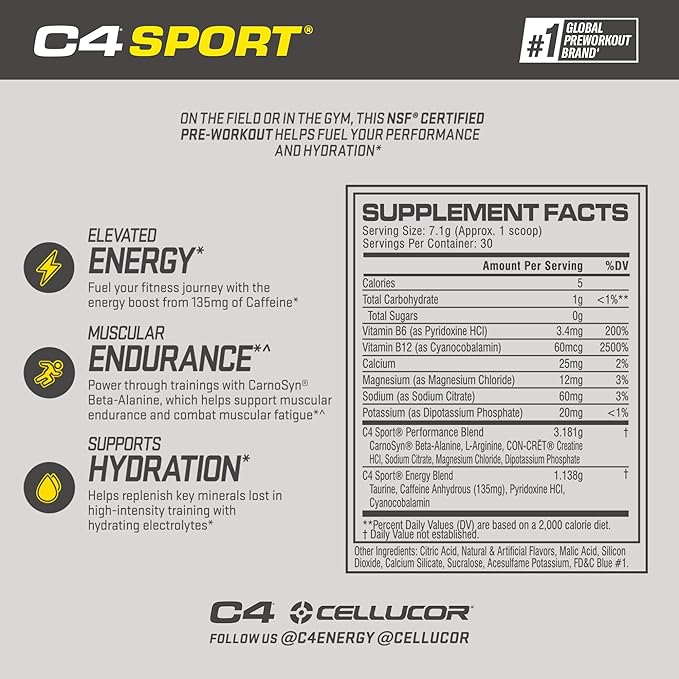

---------------------------
Result 2:
  Score: 2.0
  Source Document: health-supplement-creatine-animalpack-1.jpg
  Chunk: IM CREATINE LIMITES OR FALLER MONOHYDRATE' + Micronized Creatine Monohydrate + Muscle Building & Recovery1 + Boosted Cognitive Function1 POWDER UNFLAVORED Dietary Supplement | Net Wt. 10.58oz (300g)
---------------------------
Result 3:
  Score: 2.0
  Source Document: health-supplement-coq10-sportsresearch-1.jpg
  Chunk: SPORTS RESEARCH® COQ10 USP Grade 100MG PER SERVING WITH BIOPERINE® BLACK PEPPER EXTRACT VEGAN | GLUTEN-FREE | WITH COCONUT MCT 120 Veggie Softgels | Dietary Supplement
---------------------------
Result 4:
  Score: 1.0
  Source Document: health-supplement-astaxanthin-sportsresearch-1.jpg
  Chunk: SPORTS RESEARCH® ASTAXANTHIN Mini-Gels 6MG PER SERVING SUPPORTS ANTIOXIDANT ACTIVITY* GLUTEN-FREE | NON-GMO | WITH COCONUT OIL 120 Softgels | Dietary Supplement
---------------------------
Result 5:
  Score: 1.0
  Source Document: health-supplement-biotin-

In [9]:
# Query Type: Full
query="title:Vitamin C*"

results=search_client.search(  
    query_type='full',
    search_text=query, 
    select=["title","chunk"],
    top=5
)  

n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    print(f"  Chunk: {result['chunk']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 300, 300)
    print("---------------------------")
    n += 1

#### [Vector Search](https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-query)

* To query a vector field, the query itself must be a vector.
* One approach for converting a user's text query string into its vector representation is to call an embedding library or API in your application code. As a best practice, always use the same embedding models used to generate embeddings in the source documents. 
* A second approach is using integrated vectorization, now generally available, to have Azure AI Search handle your query vectorization inputs and outputs.

Result 1:
  Score: 0.6628427
  Source Document: health-supplement-vitaminc-naturemade-1.jpg
  Chunk: VITAMING PHARMACIST RECOMMENDED SUPPLEMENT BRAND Nature Made® C 500 mg Antioxidant Helps support support+ the immune system+ 100 TABLETS Dietary Supplement


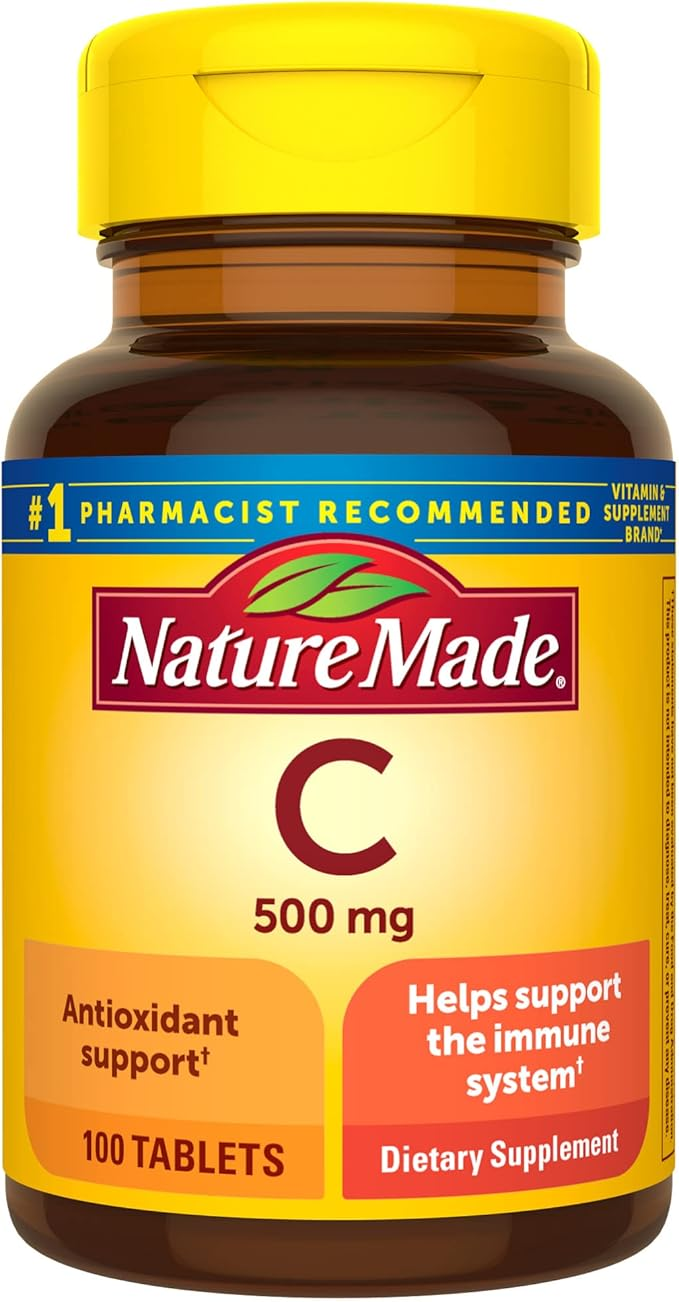

---------------------------
Result 2:
  Score: 0.65712255
  Source Document: health-supplement-vitaminc-emergenc-1.jpg
  Chunk: Naturally, It's Good for You Emergen.C 24 Nutrients 7 B Vitamins 1,000 MG Electrolytes Vitamin C DIETARY SUPPLEMENT Super Orange Antioxidants Flavored Fizzy Drink Mix 30 PACKETS . NET WT. 9.3 OZ (264 g)
---------------------------
Result 3:
  Score: 0.6446284
  Source Document: health-supplement-vitamins-muscletech-1.jpg
  Chunk: MUSCLETECH PLATINUM OVER 100% MULTI DAILY VALUE OF VITAMIN C&E VITAMIN ENZYMES & MINERALS DAILY NUTRITIONAL IMMUNE SUPPORT FOR ACTIVE SUPPORT INDIVIDUALS FROM VITAMIN C & ZINC1,4 18 816MG 401MG VITAMINS & MINERALS AMINO HERBAL SUPPORT MATRIX+ 90 TABLETS #Per Serving DIETARY SUPPLEMENT
---------------------------
Result 4:
  Score: 0.6434372
  Source Document: health-supplement-vitamine-naturewise-1.jpg
  Chunk: naturewise Sup --- Serum VITAMIN E 400 IU Vtanri Other igil CH Antioxidant Support* E Immune Support* Promotes Overall Heart 

In [12]:
# Query Type: Vector Search
query="Vitamin C"

# Azure AI Search - Vector Search
# The vector query finds 50 nearest neighbor matches in the search index
# Python VectorizableTextQuery Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.models.vectorizabletextquery?view=azure-python
vector_query=VectorizableTextQuery(
    text=query, 
    k_nearest_neighbors=50, 
    fields="text_vector"
)

# Retrieve the selected fields from the search index related to the question.
# Python search method: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.searchclient?view=azure-python#azure-search-documents-searchclient-search
results=search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["title","chunk"],
    top=5
)  
  
n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    print(f"  Chunk: {result['chunk']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 200, 200)
    print("---------------------------")
    n += 1

#### [Hybrid Search (Keyword and Vector Search)](https://learn.microsoft.com/en-us/azure/search/hybrid-search-overview)

Result 1:
  Score: 0.032522473484277725
  Source Document: health-supplement-vitamins-muscletech-1.jpg
  Chunk: MUSCLETECH PLATINUM OVER 100% MULTI DAILY VALUE OF VITAMIN C&E VITAMIN ENZYMES & MINERALS DAILY NUTRITIONAL IMMUNE SUPPORT FOR ACTIVE SUPPORT INDIVIDUALS FROM VITAMIN C & ZINC1,4 18 816MG 401MG VITAMINS & MINERALS AMINO HERBAL SUPPORT MATRIX+ 90 TABLETS #Per Serving DIETARY SUPPLEMENT


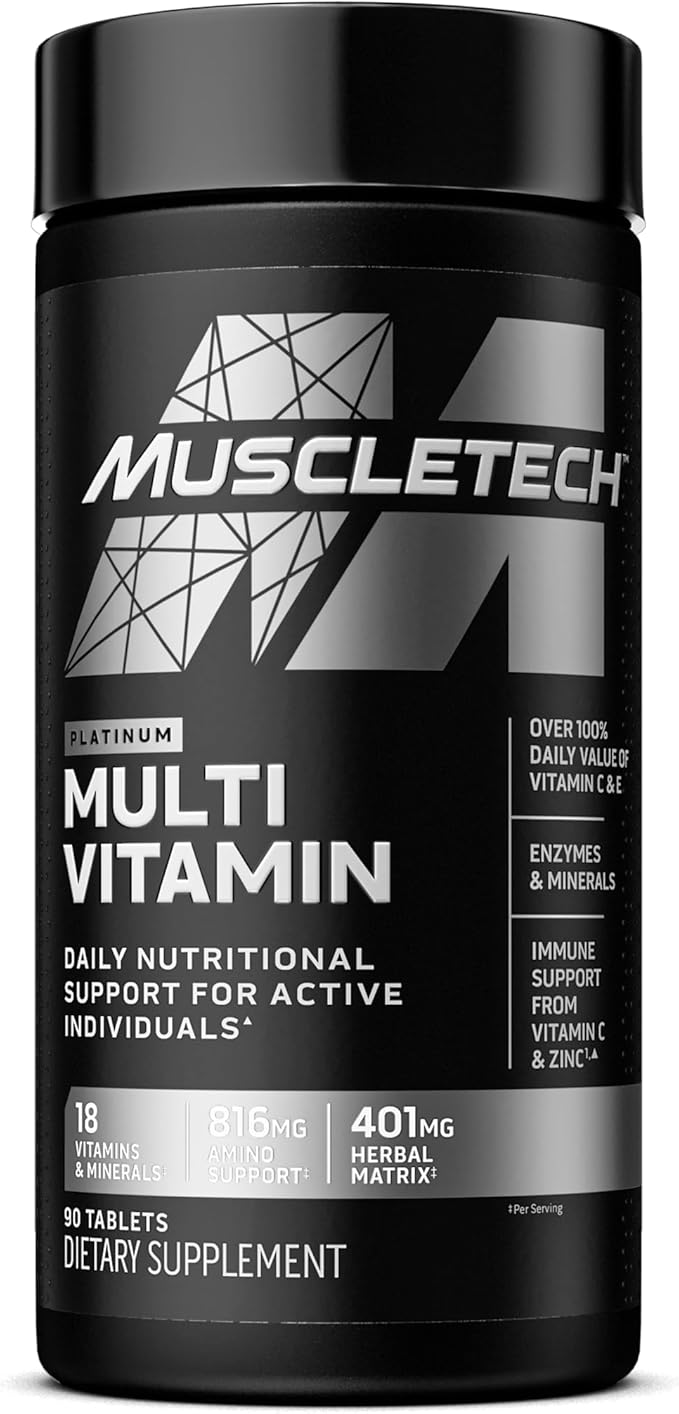

---------------------------
Result 2:
  Score: 0.032522473484277725
  Source Document: health-supplement-vitaminc-emergenc-1.jpg
  Chunk: Naturally, It's Good for You Emergen.C 24 Nutrients 7 B Vitamins 1,000 MG Electrolytes Vitamin C DIETARY SUPPLEMENT Super Orange Antioxidants Flavored Fizzy Drink Mix 30 PACKETS . NET WT. 9.3 OZ (264 g)
---------------------------
Result 3:
  Score: 0.03205128386616707
  Source Document: health-supplement-vitamins-newage-1.jpg
  Chunk: 2 pack NEW AGE NEW AGE IMMUNE SUPPORT IMMUNE SUPPORT 8- IN -1 8- IN -1 VITAMIN C ECHINACEA VITAMIN C ECHINACEA GINGER TURMERIC GINGER TURMERIC ELDERBERRY VITAMIN B6 ELDERBERRY VITAMIN VITAMIN D3 ZINC VITAMIN D3 ZIN 60 CAPSULES 60 CAPSULES DIETARY SUPPLEMENT DIETARY SUPPLE
---------------------------
Result 4:
  Score: 0.03181818127632141
  Source Document: health-supplement-vitaminc-naturemade-1.jpg
  Chunk: VITAMING PHARMACIST RECOMMENDED SUPPLEMENT BRAND Nature Made® C 500 mg Antioxidant Helps support support+ the im

In [13]:
# Query Type: Hybrid Search #1 - Search the text_vector field
query="Vitamin C"

# Azure AI Search - Vector Search
# Python VectorizableTextQuery Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.models.vectorizabletextquery?view=azure-python
vector_query=VectorizableTextQuery(
    text=query, 
    k_nearest_neighbors=50, 
    fields="text_vector"
)

# Python search method: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.searchclient?view=azure-python#azure-search-documents-searchclient-search
results=search_client.search(  
    search_text=query,  
    vector_queries= [vector_query],
    select=["title","chunk"],
    top=5
)  
  
n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    print(f"  Chunk: {result['chunk']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 200, 200)
    print("---------------------------")
    n += 1

Result 1:
  Score: 0.01666666753590107
  Source Document: health-supplement-vitamins-newage-1.jpg


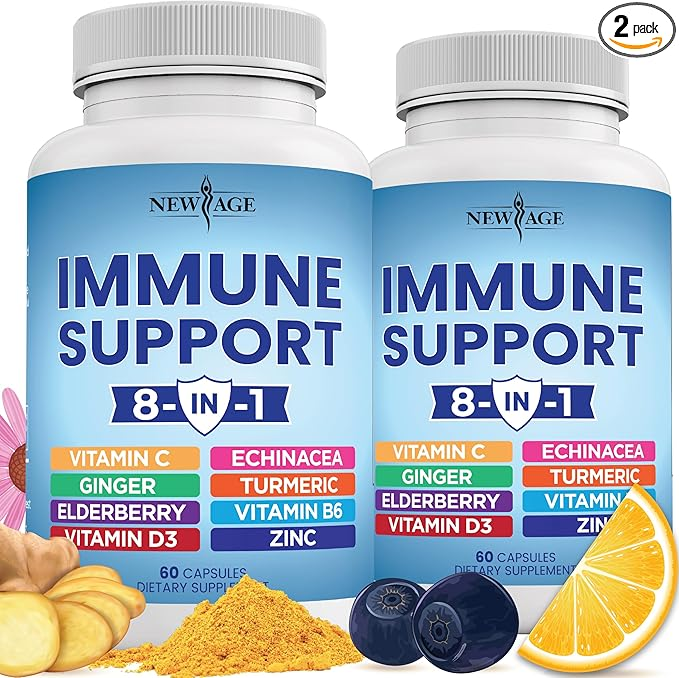

---------------------------
Result 2:
  Score: 0.01666666753590107
  Source Document: health-supplement-vitaminc-naturemade-1.jpg
---------------------------
Result 3:
  Score: 0.016393441706895828
  Source Document: health-supplement-vitamins-muscletech-1.jpg
---------------------------
Result 4:
  Score: 0.016393441706895828
  Source Document: health-supplement-vitaminc-emergenc-1.jpg
---------------------------
Result 5:
  Score: 0.016129031777381897
  Source Document: health-supplement-vitamins-vitafusion-1.jpg
---------------------------


In [14]:
# (OPTIONAL) Query Type: Hybrid Search #2 - Search the image_vector field
query="Vitamin C"

vector_query=VectorizableTextQuery(
    text=query, 
    k_nearest_neighbors=50, 
    fields="image_vector"
)

results=search_client.search(  
    search_text=query,  
    vector_queries= [vector_query],
    select=["title"],
    top=5
)  

n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 300, 300)
    print("---------------------------")
    n += 1

#### [Semantic Ranking](https://learn.microsoft.com/en-us/azure/search/semantic-search-overview)

Result 1:
  Score: 0.03159204125404358
  Source Document: health-supplement-vitamins-vimerson-1.jpg
  Chunk: Vimerson Health GMO Free | Gluten Free | Dairy Free | Soy Free MULTIVITAMIN FOR MEN All-in-One Support* Potent Energizer* Memory & Focus* 20 Vitamins & Minerals 60 CAPSULES 30 DAY Dietary Supplement SUPPLY


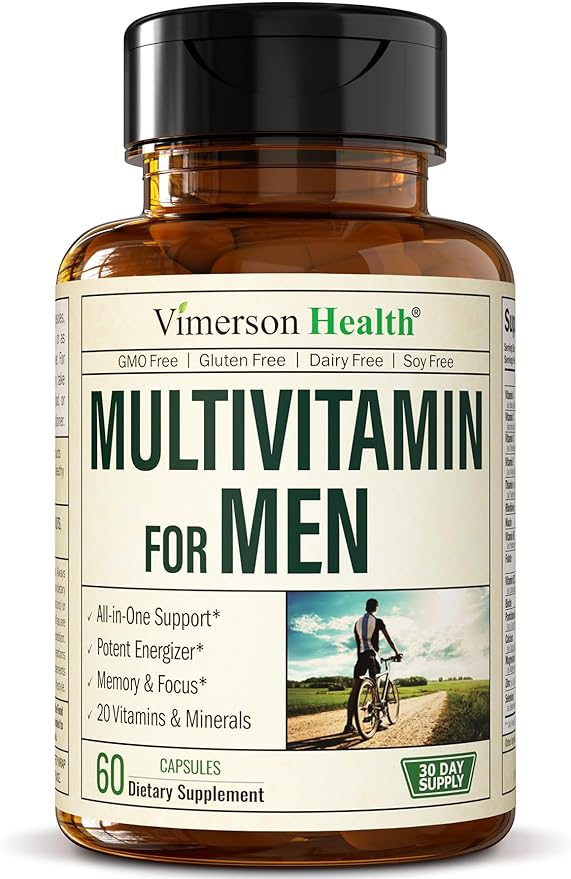

---------------------------
Result 2:
  Score: 0.014925372786819935
  Source Document: health-supplement-vitamins-olly-1.jpg
  Chunk: OLLY® 150 mcg BIOTIN BLISSFUL BERRY Flavored with other Natural Flavors PER 2 GUMMIES WOMEN'S MULTI A Multitasking Blend of Vitamins 90 A, C, D, E, Bs, Biotin & Folic Acid GUMMIES DIETARY SUPPLEMENT OLLY
---------------------------
Result 3:
  Score: 0.016129031777381897
  Source Document: health-supplement-vitamins-vitafusion-1.jpg
  Chunk: vitafusion® multivites supports energy metabolism, eye, muscle & immune health* BERRY, PEACH & ORANGE FLAVORS 150 GUMMIES DIETARY SUPPLEMENT
---------------------------
Result 4:
  Score: 0.01587301678955555
  Source Document: health-supplement-vitamins-muscletech-1.jpg
  Chunk: MUSCLETECH PLATINUM OVER 100% MULTI DAILY VALUE OF VITAMIN C&E VITAMIN ENZYMES & MINERALS DAILY NUTRITIONAL IMMUNE SUPPORT FOR ACTIVE SUPPORT INDIVIDUALS FROM VITAMIN C & ZINC1,4 18 816MG 401MG VITAMINS & MINERALS AMINO HERBAL SUPPORT MATRIX+

In [16]:
# Query
query="Find only the multivitamin supplements"

# Azure AI Search - Vector Search
# Python VectorizableTextQuery Class: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.models.vectorizabletextquery?view=azure-python
vector_query=VectorizableTextQuery(
    text=query, 
    k_nearest_neighbors=50, 
    fields="text_vector"
)

# Python search method: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.searchclient?view=azure-python#azure-search-documents-searchclient-search
results=search_client.search(  
    search_text=query,  
    query_type="semantic",
    semantic_configuration_name=semantic_config_name,
    vector_queries= [vector_query],
    select=["title","chunk"],
    top=5
)  
  
n=1
for result in results:  
    print(f"Result {n}:")
    print(f"  Score: {result['@search.score']}")
    print(f"  Source Document: {result['title']}")
    print(f"  Chunk: {result['chunk']}")
    if n == 1:
        display_image("../images-aisearch/{0}".format(result['title']), 200, 200)
    print("---------------------------")
    n += 1

## Retrieval Augmented Generation (RAG) Pattern

### [Search your data using a Chat GPT model](https://learn.microsoft.com/en-us/azure/search/tutorial-rag-build-solution-query)

The defining characteristic of a RAG solution on Azure AI Search is sending queries to a Large Language Model (LLM), in this case Azure OpenAI GPT-4o, for a conversational search experience over your indexed content. 

The provided answer by Azure AI Search is based on three to five inputs (top=3 / top=5) consisting of chunks determined by the search engine to be the most relevant. 

Instructions in the OpenAI Chat Completion Prompt tell the LLM to use only the information in the sources, or formatted search results.

In [33]:
# Python AzureOpenAI Class: https://github.com/openai/openai-python?tab=readme-ov-file#microsoft-azure-openai
openai_client=AzureOpenAI(
     api_version="2024-06-01",
     azure_endpoint=AZURE_OPENAI_ACCOUNT,     
     api_key=AZURE_OPENAI_KEY
)

### Search your data in two steps

In [36]:
# RAG with Vector Search
# Provide Prompt Engineering instructions to the model
GROUNDED_PROMPT="""
You are an AI assistant designed to help users learn from the information found in the provided source material.
- Answer the query using only the sources listed below.
- Answer ONLY with the facts from the sources below.
- Use bullet points for answers with multiple points.
- If the answer exceeds 3 sentences, include a summary.
- Cite your sources using the title field.
- If there isn't enough information, state that you don't know.
- Do not generate answers that don't use the sources below.
Query: {query}
Sources: {sources}
"""

In [37]:
# Azure AI Search search query. 
query_aisearch="Multivitamin supplements"

vector_query=VectorizableTextQuery(
    text=query_aisearch, 
    k_nearest_neighbors=50, 
    fields="text_vector"
)

# Get Azure AI Search results.
# Search results are limited to the top 5 matches. Limiting top can help you stay under LLM quotas.
search_results=search_client.search(
    search_text=query_aisearch,
    vector_queries= [vector_query],
    select=["title", "chunk"],
    top=5
)

# Format the Azure AI Search results
sources_formatted = "\n".join([f'TITLE: {document["title"]}, CONTENT: {document["chunk"]}'for document in search_results])

# Azure OpenAI Query
query="Find multivitamin supplements, order them based on the quantity of vitamins, \
    and provide a brief explanation for the selected order."

# Send Azure AI results to Azure OpenAI
# Python openai.chat.completions.create method: https://platform.openai.com/docs/guides/text-generation
response=openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT.format(query=query, sources=sources_formatted)
        }
    ],
    model=azure_openai_gpt4o_name
)

# Print Azure OpenAI result
print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
- **1. Naturelo Multivitamin:** Contains 23 vitamins and minerals, plus whole foods like organic
fruits and vegetables, offering the highest quantity of vitamins and minerals. (Source:
health-supplement-vitamins-naturelo-1.jpg)  

- **2. Muscletech Platinum Multivitamin:** Includes
18 vitamins and minerals, along with an additional herbal support matrix and amino enzymes.
(Source: health-supplement-vitamins-muscletech-1.jpg)

- **3. Vimerson Health Multivitamin:**
Provides 20 vitamins and minerals specifically tailored for men. (Source:
health-supplement-vitamins-vimerson-1.jpg)

- **4. One A Day Multivitamin:** Offers nutritional
support for six key functions with an unspecified number of vitamins and minerals. (Source:
health-supplement-vitamins-oneaday-1.jpg)

- **5. Naturewise Multivitamin:** Contains vitamins and
minerals as part of a whole food complex without specifying the exact count. (Source:
health-supplement-vitamins-naturewise-1.jpg)

**S

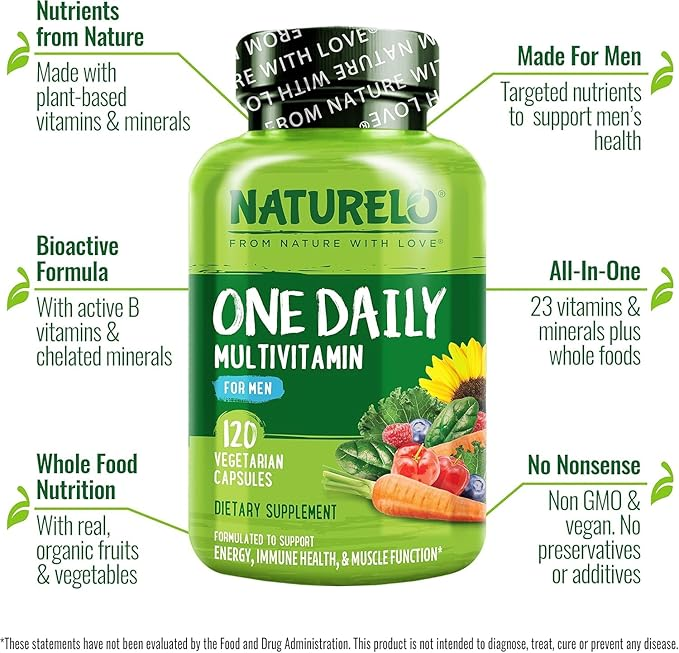

In [ ]:
# Display the image
# Azure AI Search images path: ""../images-aisearch/"
display_image("../images-aisearch/health-supplement-vitamins-naturelo-1.jpg", 300, 300)

### Update queries for semantic ranking in two steps

This example modifies the query request to include the semantic configuration.

Adding semantic ranking positively affects the response from the LLM by promoting results that meet scoring criteria and are semantically relevant.

In [38]:
# RAG with Semantic Ranking
# Instructions to the model provided in variable: GROUNDED_PROMPT
# Reusing the previous query_aisearch
# Reusing the previous Text Vectorizer (vector_query=VectorizableTextQuery)

# Add query_type semantic and semantic_configuration_name
search_results=search_client.search(
    query_type="semantic",
    semantic_configuration_name=semantic_config_name,
    search_text=query_aisearch,
    vector_queries=[vector_query],
    select=["title", "chunk"],
    top=5
)

sources_formatted="\n".join([f'TITLE: {document["title"]}, CONTENT: {document["chunk"]}' for document in search_results])

# Azure OpenAI Query
query="Find multivitamin supplements, order them based on the quantity of vitamins, \
    and provide a brief explanation for the selected order."

response=openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT.format(query=query, sources=sources_formatted)
        }
    ],
    model=azure_openai_gpt4o_name
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
- **Ranked Order of Multivitamins by Quantity of Vitamins:**
  1. **MUSCLETECH**: Over 100% daily
value of Vitamin C & E, includes enzymes, minerals, and an amino-herbal support matrix. Total: 18
vitamins & minerals.  
     - Source: health-supplement-vitamins-muscletech-1.jpg  
  2. **Vimerson
Health**: Contains 20 vitamins and minerals.  
     - Source:
health-supplement-vitamins-vimerson-1.jpg  
  3. **OLLY**: Includes Vitamins A, C, D, E, Bs,
Biotin, and Folic Acid. Relative to others, it specifies the inclusion of fewer vitamins.    
    
- Source: health-supplement-vitamins-olly-1.jpg  
  4. **One A Day**: General multivitamin covering
6 key functions but does not specify a detailed vitamin count or breakdown.  
     - Source:
health-supplement-vitamins-oneaday-1.jpg  
  5. **Vitafusion**: Supports energy metabolism, eye,
muscle, and immune health but does not specify the number of vitamins included.   
     - Source:
health-supplement-vitamins-

### Search your data in a single Azure OpenAI call

* [Setting the context](https://cookbook.openai.com/examples/azure/chat_with_your_own_data#chat-completion-model-with-your-own-data)
* [Azure OpenAI On Your Data API Reference](https://learn.microsoft.com/en-us/azure/ai-services/openai/references/on-your-data?tabs=python)
* [Azure AI Search - Data source parameters](https://learn.microsoft.com/en-us/azure/ai-services/openai/references/azure-search?tabs=python)
  * [Deployment name vectorization source parameter](https://learn.microsoft.com/en-us/azure/ai-services/openai/references/azure-search?tabs=python#deployment-name-vectorization-source)
* [Azure AI Search as DataSource Example 1](https://learn.microsoft.com/en-us/azure/ai-services/openai/reference)
* [Azure AI Search as DataSource Example 2](https://learn.microsoft.com/en-us/azure/ai-services/openai/reference#example-4)

> 📝 Note:
> * If the Prompt Engineering Instructions are not well structure, the following outpu may be generated:
>   * _The requested information is not available in the retrieved data. Please try another query or
topic_

In [16]:
# RAG with Simple Search query from Chat GPT-4o
response=openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        {
            "role": "user",
            "content": "Find the best supplements for gaining muscle mass and explain why.",
        },
    ],
    extra_body={
        "data_sources":[
            {
                "type": "azure_search",
                "parameters": {
                    "endpoint": AZURE_SEARCH_SERVICE,
                    "index_name": azureai_index_name,
                    "authentication": {
                        "type": "api_key",
                        "key": AZURE_SEARCH_KEY
                    }
                }
            }
        ],
    }
)

# Print the full json response
print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")


Azure OpenAI full json response:
{
  "id": "9a02a80f-860a-4606-b518-4cbc951a2f36",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "The requested information is not available in the retrieved data. Please try another query or topic.",
        "refusal": null,
        "role": "assistant",
        "audio": null,
        "function_call": null,
        "tool_calls": null,
        "end_turn": true,
        "context": {
          "citations": [
            {
              "content": "50 GRAMS PROTEIN 3 GRAMS TM MUSCLE MILK 50 GRAMS SUGAR* PROTEIN MM 3 GRAMS SUGAR PER SERVING PER SERVING EXCELLENT SOURCE OF 20 VITAMINS AND MINERALS EXCELLENT SOURCE OF 20 VITAMINS AND MINERALS PROSERIES NSF. CERTIFIED SPORT PROTEIN POWDER SUPPLEMENT HELPS SUPPORT MUSCLE REBUILDING &amp; RECOVERY++ NSF KNOCKOUT CHOCOLATE ARTIFICIALLY FLAVORED CERTIFIED SPORT NET WT 40.7 OZ (2.54 LB) 1.15 kg NOTICE: Use this productun ifal Do no

In [39]:
# Provide new instructions to the model
GROUNDED_PROMPT_AOAI="""
You are an AI assistant designed to help users learn from the information found in the Azure AI Search results.
- Answer the query using only the sources listed by the Azure AI Search data source.
- Answer ONLY with the facts from the sources and data found in message, context and citations.
- Use bullet points for answers with multiple points.
- If the answer exceeds 3 sentences, include a summary.
- Cite your sources using the title field found in message, context and citations.
- If there isn't enough information, state that you don't know.
Query: {query}
"""

In [18]:
# RAG with Semantic Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

#Query
query="Find the best supplements for gaining muscle mass and explain why."

response=openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body={
        "data_sources":[
            {
                "type": "azure_search",
                "parameters": {
                    "endpoint": AZURE_SEARCH_SERVICE,
                    "index_name": azureai_index_name,
                    "authentication": {
                        "type": "api_key",
                        "key": AZURE_SEARCH_KEY
                    },
                    "query_type": "semantic",
                    "semantic_configuration": semantic_config_name
                }
            }
        ]
    }    
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
The retrieved documents provide information on several supplements that can aid in gaining muscle
mass. Here are the details:

### Supplements for Gaining Muscle Mass:
1. **GNC AMP Advanced Muscle
Performance Wheybolic**:
   - Contains 40g of protein and 15g of essential amino acids (EAA) per
serving.
   - Includes 6.2g of leucine, which is crucial for muscle protein synthesis.
   - Proven
to increase muscle strength in as early as two weeks and supports testosterone levels and power
[health-supplement-protein-gnc-1.jpg].

2. **MuscleTech Nitro Whey Protein**:
   - Provides 30g of
protein, 3g of creatine, and 6.7g of branched-chain amino acids (BCAAs) per serving.
   - Designed
to help build lean muscle and support recovery [health-supplement-protein-muscletech-1.jpg].

3.
**Muscle Milk Pro Series**:
   - Offers 50g of protein and is an excellent source of 20 vitamins
and minerals.
   - Helps support muscle rebuilding and recovery
[health-supplement-p

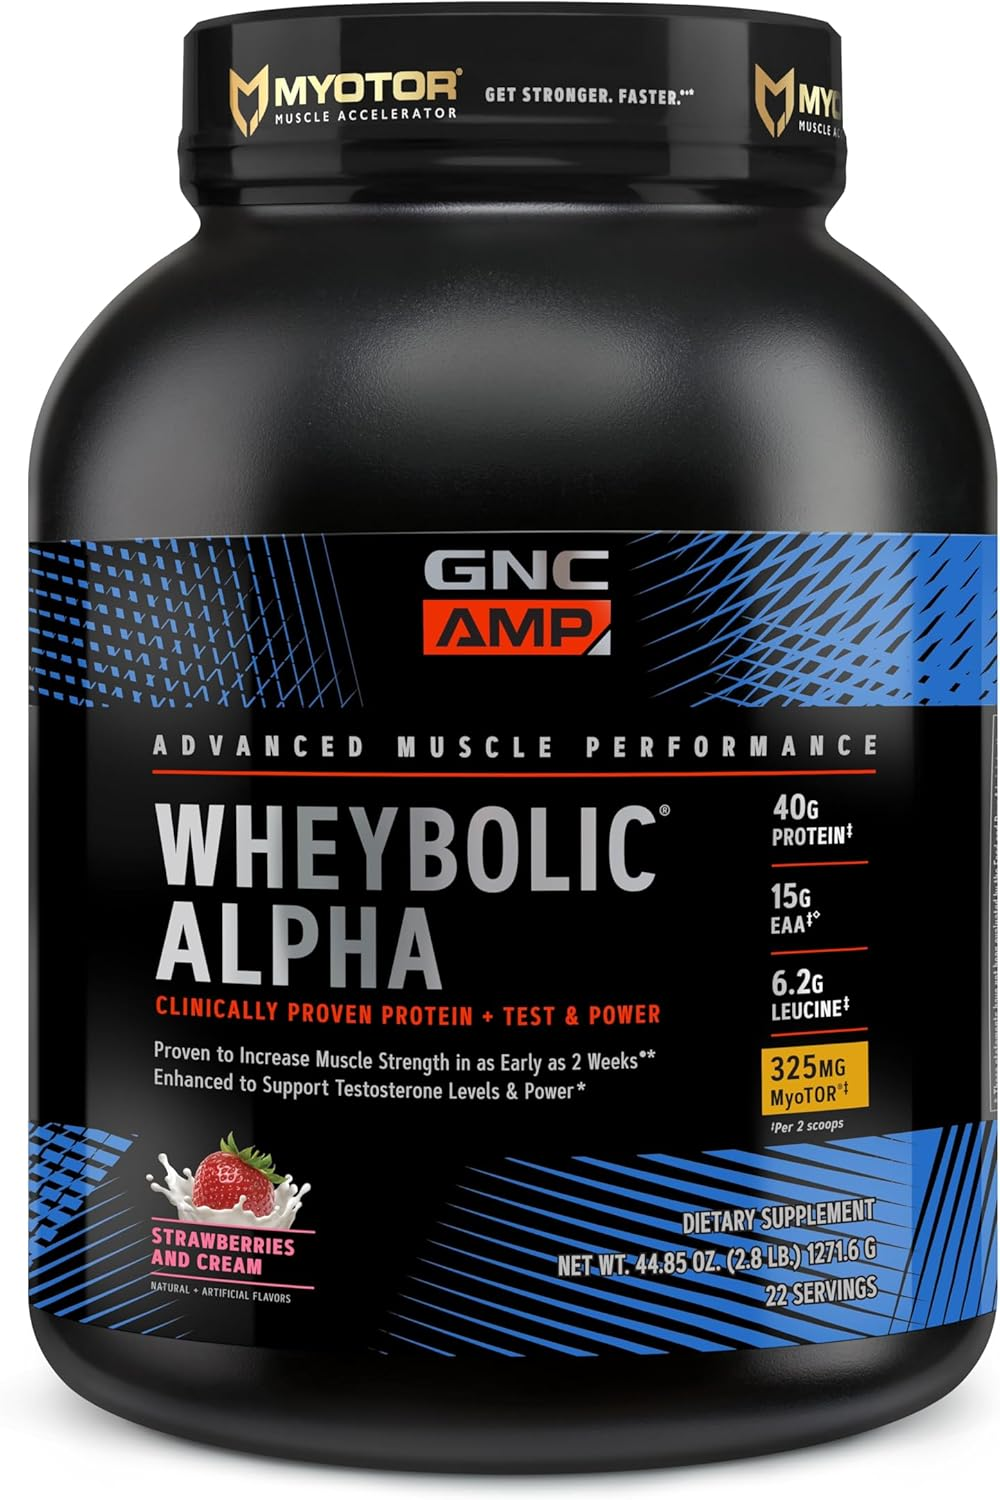

In [18]:
# Display the image
# Azure AI Search images path: ""../images-aisearch/"
display_image("../images-aisearch/health-supplement-protein-gnc-1.jpg", 300, 300)

In [19]:
# RAG with Hybrid (Vector and Semantic) Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

#Query
query="Find the best supplements for gaining muscle mass and explain why."

response=openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body={
        "data_sources":[
            {
                "type": "azure_search",
                "parameters": {
                    "endpoint": AZURE_SEARCH_SERVICE,
                    "index_name": azureai_index_name,
                    "authentication": {
                        "type": "api_key",
                        "key": AZURE_SEARCH_KEY
                    },                
                    "semantic_configuration": semantic_config_name,
                    "embedding_dependency": {
                        "deployment_name": azure_openai_embedding,
                        "type": "deployment_name"
                        },
                    "query_type": "vector_semantic_hybrid",
                    "fields_mapping": {
                        "vector_fields": [
                            "text_vector"                            
                        ]
                    }
                }
            }
        ],
    }
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
The retrieved documents provide information on several supplements that can aid in gaining muscle
mass. Here are the details:

### Supplements for Gaining Muscle Mass:
1. **GNC AMP Advanced Muscle
Performance Wheybolic**:
   - Contains 40g of protein and 15g of essential amino acids (EAA) per
serving.
   - Includes 6.2g of leucine, which is crucial for muscle protein synthesis.
   - Proven
to increase muscle strength in as early as two weeks and supports testosterone levels for enhanced
power [health-supplement-protein-gnc-1.jpg].

2. **MuscleTech Nitro-Tech**:
   - Provides 30g of
protein, 3g of creatine, and 6.7g of branched-chain amino acids (BCAAs) per serving.
   - Designed
to help build lean muscle and support recovery.
   - Contains whey protein, which is a
fast-digesting protein ideal for muscle repair and growth
[health-supplement-protein-muscletech-1.jpg].

3. **Muscle Milk Pro Series**:
   - Offers 50g of
protein and 20 vitamins and mineral

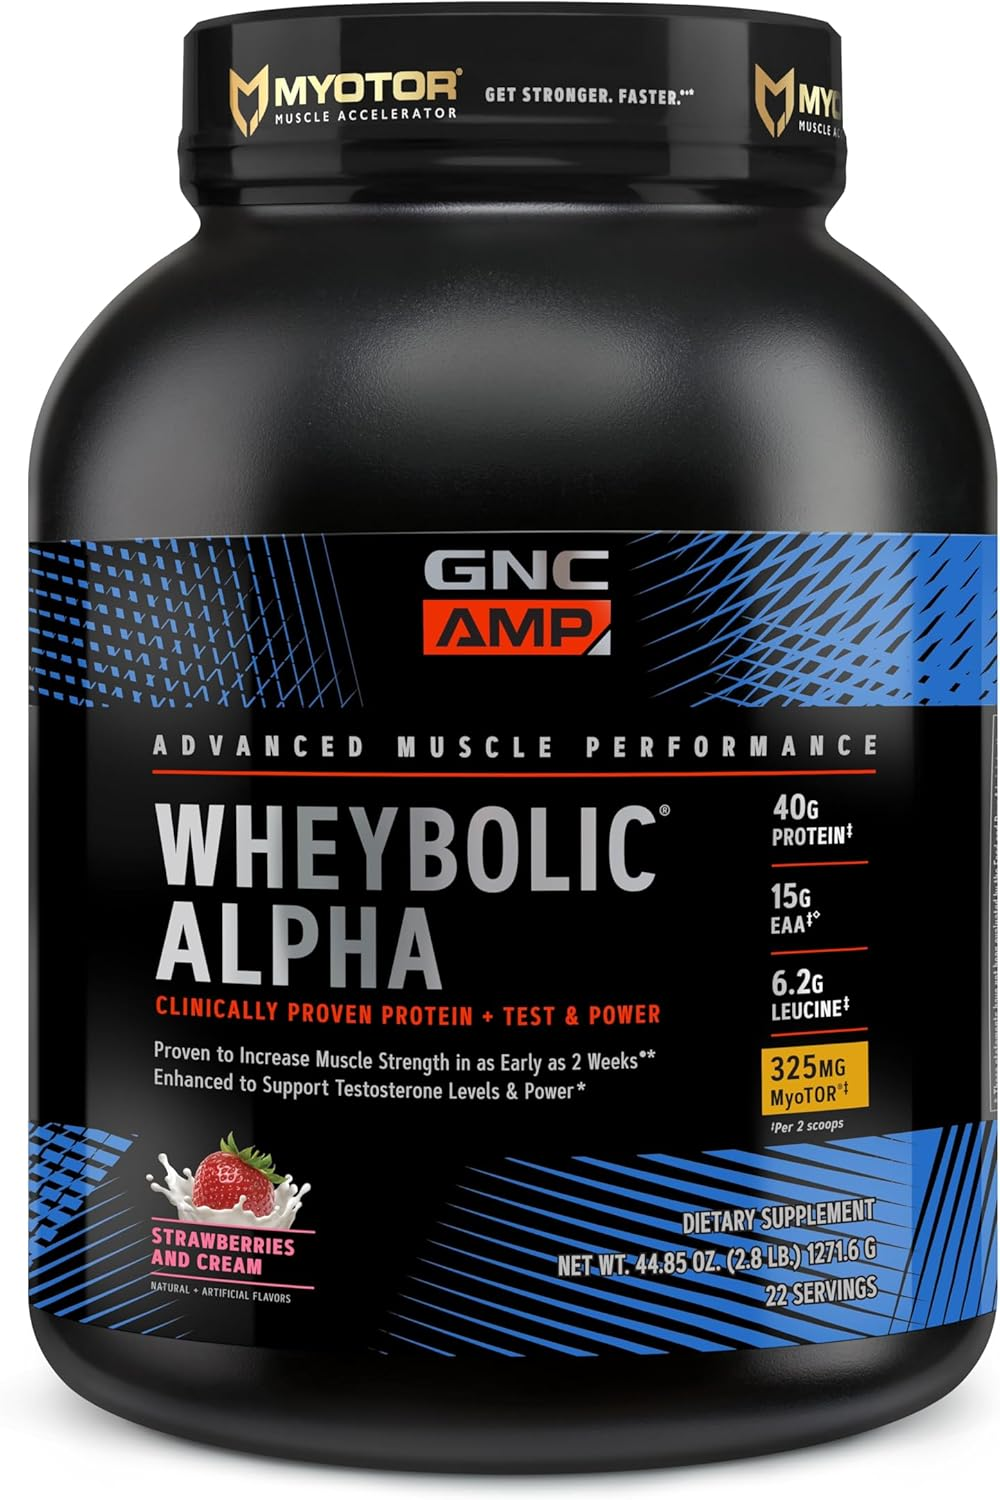

In [21]:
# Display the image
# Azure AI Search images path: ""../images-aisearch/"
display_image("../images-aisearch/health-supplement-protein-gnc-1.jpg", 300, 300)

### AzureOpenAI call using a a Local Image

1. First convert the image file to base64 so it can be passed to the API
1. Send the base64 file to Azure OpenAI API using the image_url field. 

#### Image Analysis 1

In [42]:
# Add and test local image 1
image_path='../images-aisearch/health-supplement-protein-muscletech-1.jpg'
data_url=local_image_to_data_url(image_path)
#print("Data URL:", data_url)

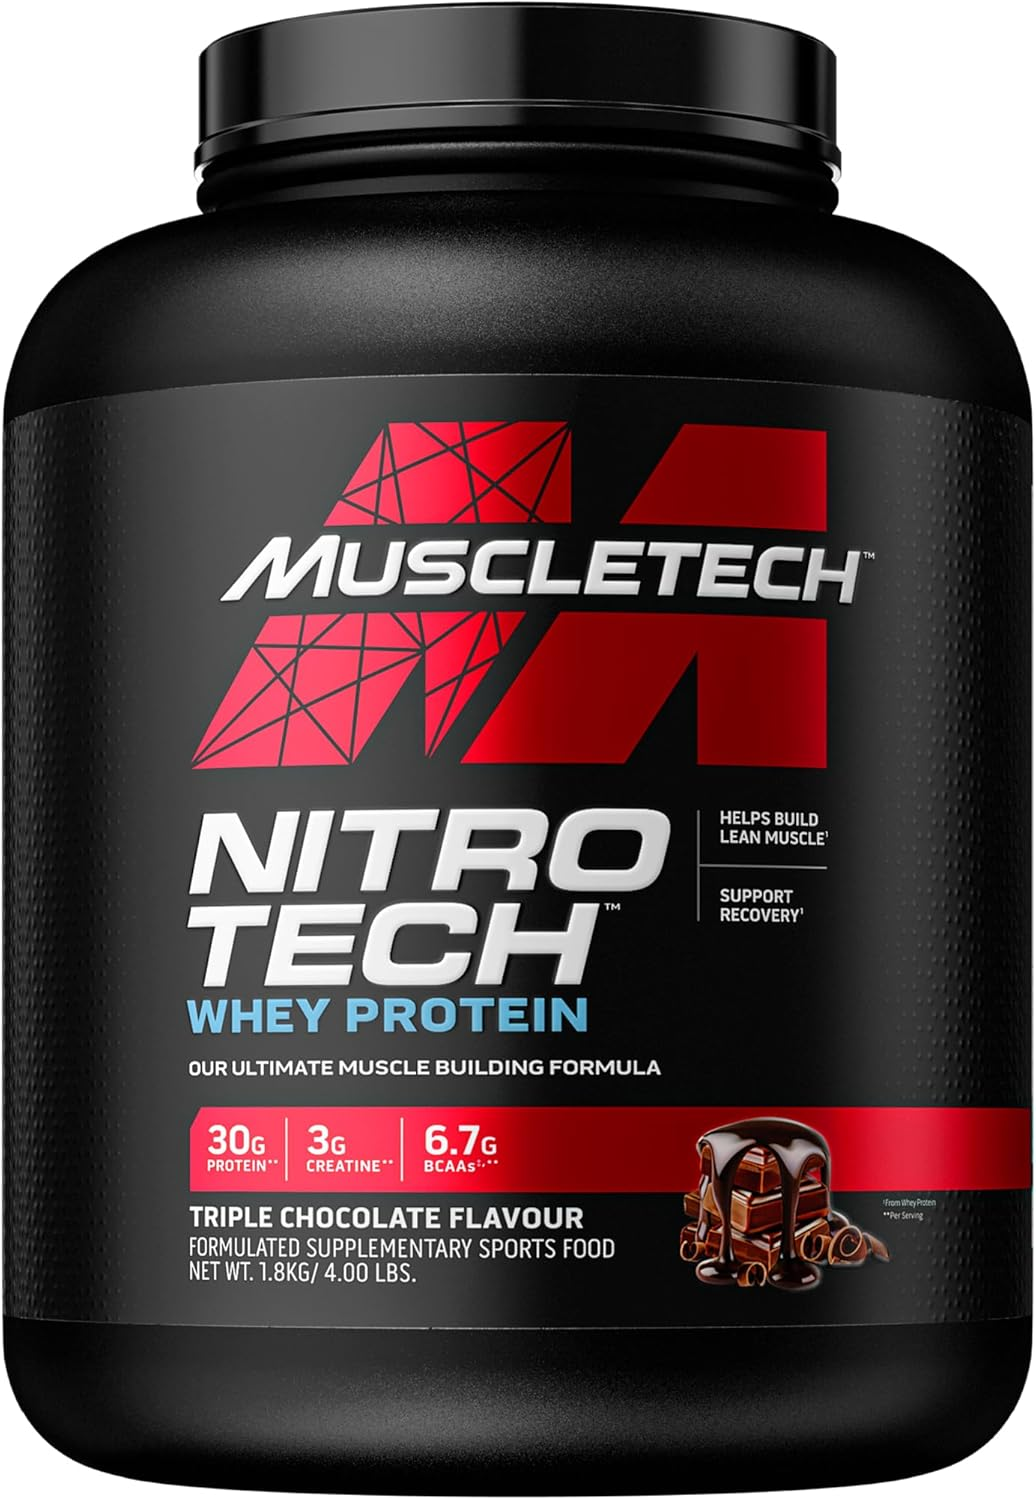

In [43]:
# Display the image
# Azure AI Search images path: ""../images-aisearch/"
display_image(image_path, 300, 300)

In [44]:
# Azure AI Search semantic configuration and hybrid search
azureaisearch_config = {
        "data_sources":[
            {
                "type": "azure_search",
                "parameters": {
                    "endpoint": AZURE_SEARCH_SERVICE,
                    "index_name": azureai_index_name,
                    "authentication": {
                        "type": "api_key",
                        "key": AZURE_SEARCH_KEY
                    },                
                    "semantic_configuration": semantic_config_name,
                    "embedding_dependency": {
                        "deployment_name": azure_openai_embedding,
                        "type": "deployment_name"
                        },
                    "query_type": "vector_semantic_hybrid",
                    "fields_mapping": {
                        "vector_fields": [
                            "text_vector"                            
                        ]
                    }
                }
            }
        ],
    }

**Detail parameter:** The detail parameter in the model offers three choices: low, high, or auto, to adjust the way the model interprets and processes images. The default setting is auto, where the model decides between low or high based on the size of the image input.
* low setting: the model does not activate the "high res" mode, instead processes a lower resolution 512x512 version, resulting in quicker responses and reduced token consumption for scenarios where fine detail isn't crucial.
* high setting: the model activates "high res" mode. Here, the model initially views the low-resolution image and then generates detailed 512x512 segments from the input image. Each segment uses double the token budget, allowing for a more detailed interpretation of the image.

```
    # Example:
    image_url: {
        url: "https://your-image-url.com",
        detail: "low",
    }
```


In [45]:
# Image content extraction using GPT-4o
query="Extract all the text from the provided image and compile it into a paragraph."

response=openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        { 
            "role": "system", 
            "content": "You are a Visual Cognitive system tasked with extracting text and information from images." 
        },
        { 
            "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": query 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": data_url                        
                    }
                }
            ] 
        } 
    ],
    #  Set a "max_tokens" value, or the return output will be cut off
    max_tokens=3000 
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

# Save the GPT-4o output
message=response.choices[0].message.content


Azure OpenAI message content only:
MUSCLETECH NITRO-TECH WHEY PROTEIN. OUR ULTIMATE MUSCLE BUILDING FORMULA. Helps Build Lean Muscle.*
Support Recovery.* 30g Protein^, 3g Creatine^, 6.7g BCAAs^**. TRIPLE CHOCOLATE FLAVOUR. FORMULATED
SUPPLEMENTARY SPORTS FOOD. NET WT. 1.8KG / 4.00 LBS. *(From Whey Protein Per Serving).


In [ ]:
# RAG Hybrid (Vector and Semantic) Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

#Query
query="Find the nutritional supplement in the database that most closely \
    matches the following description and explain why: " + message

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    max_tokens=3000,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body=azureaisearch_config
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
The nutritional supplement in the database that most closely matches the description provided is
**MUSCLETECH™ NITRO-TECH™ WHEY PROTEIN**. Here is why:

- The product is explicitly named
**MUSCLETECH™ NITRO-TECH™** and is described as a whey protein supplement designed to help build
lean muscle and support recovery [health-supplement-protein-muscletech-1.jpg].
- It contains **30g
of protein**, **3g of creatine**, and **6.7g of BCAAs** per serving, which matches the nutritional
profile described [health-supplement-protein-muscletech-1.jpg].
- The flavor is **Triple
Chocolate**, and the net weight is **1.8kg / 4.00 lbs**, which also aligns with the provided
description [health-supplement-protein-muscletech-1.jpg].

### Summary:
The MUSCLETECH™ NITRO-TECH™
WHEY PROTEIN matches the description perfectly in terms of name, nutritional content, flavor, and
packaging details [health-supplement-protein-muscletech-1.jpg].


#### Image Analysis 2

Azure OpenAI message content only:
A supplement that enhances learning, memory, and cognitive functions.


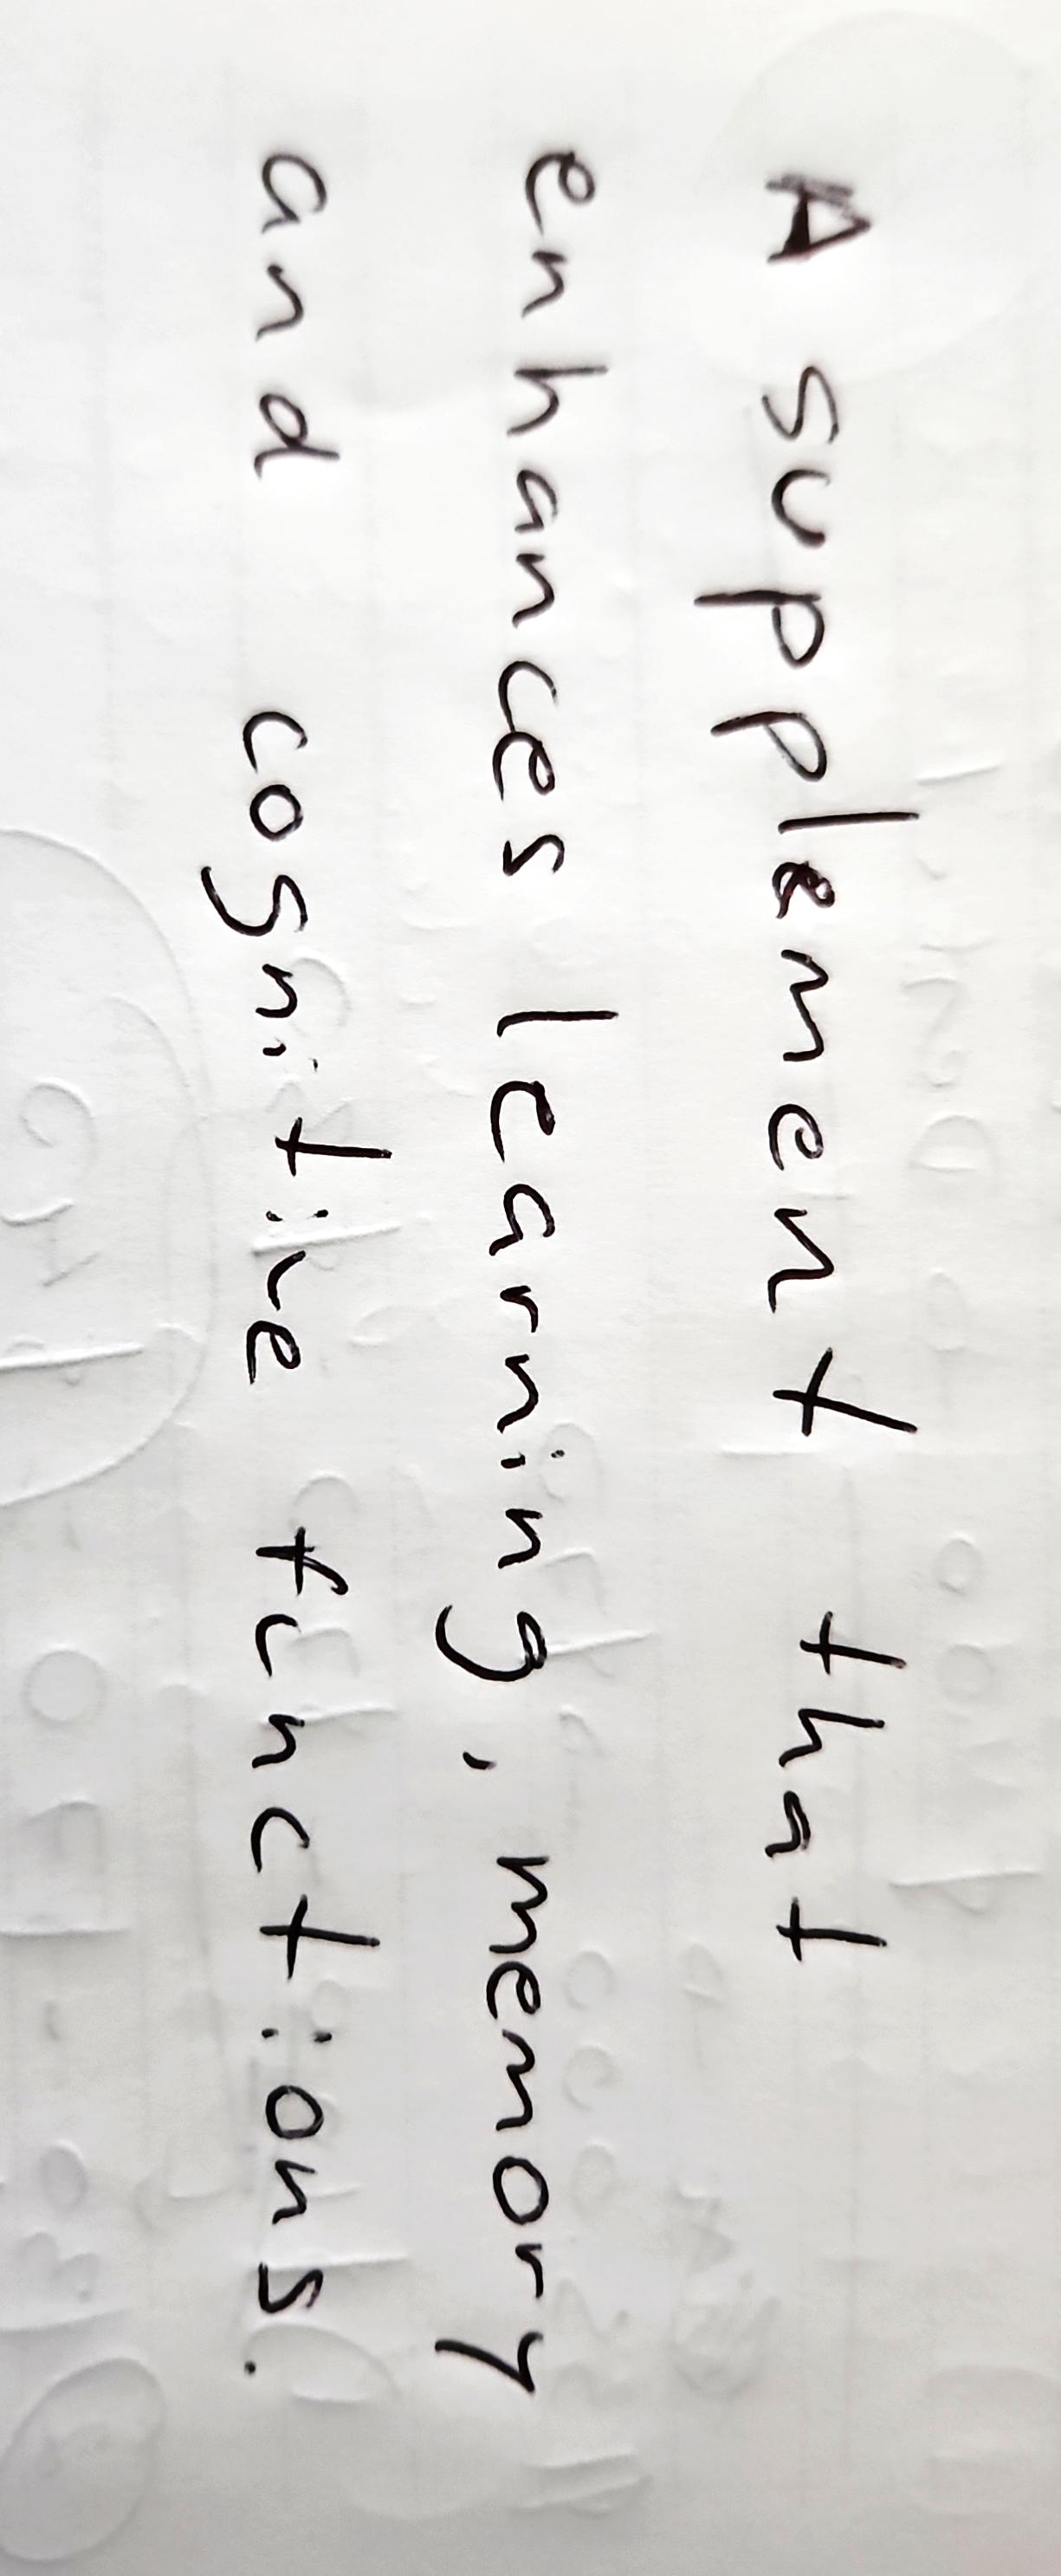

In [46]:
# Image content extraction using GPT-4o

# Add and test local image 2
image_path='../images-lab-tests/handwriting-supplement-1.jpg'
data_url=local_image_to_data_url(image_path)

query="Extract all the text from the provided image and compile it into a paragraph."

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        { 
            "role": "system", 
            "content": "You are a Visual Cognitive system tasked with extracting text and information from images." 
        },
        { 
            "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": query 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": data_url                        
                    }
                }
            ] 
        } 
    ],
    #  Set a "max_tokens" value, or the return output will be cut off
    max_tokens=3000 
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")
display_image(image_path, 300, 300)

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

# Save the GPT-4o output
message=response.choices[0].message.content


In [ ]:
# RAG Hybrid (Vector and Semantic) Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

query="Find the nutritional supplement in the database that can address \
    the following health requirement message and explain why. " + message

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    max_tokens=3000,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body=azureaisearch_config
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
- **Sports Research® Magtein**: This supplement contains 2000mg of Magnesium L-Threonate, which
supports cognitive health, making it suitable for enhancing learning, memory, and cognitive
functions [health-supplement-magtein-sportsresearch-1.jpg].

- **Animal Creatine**: This product
includes micronized creatine monohydrate, which is noted for boosting cognitive function alongside
muscle building and recovery [health-supplement-creatine-animalpack-1.jpg].

- **Naturewise Women's
Stress Support**: This multivitamin and mineral supplement supports overall cognitive health,
stress and mood management, and energy and focus, which can contribute to improved cognitive
functions [health-supplement-vitamins-naturewise-1.jpg].

### Summary:
The supplements **Sports
Research® Magtein**, **Animal Creatine**, and **Naturewise Women's Stress Support** all address
cognitive health and functions, with Magtein specifically targeting memory and learning, while the
oth

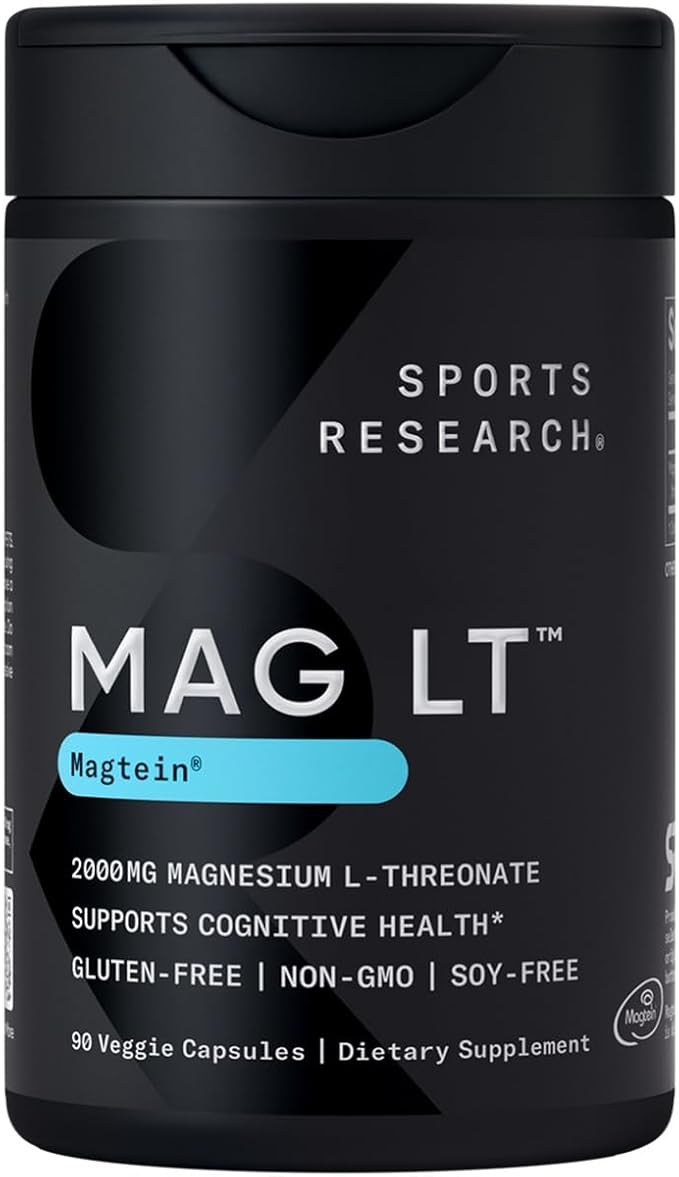

In [48]:
# Display the image
# Azure AI Search images path: "../images-aisearch/"
display_image("../images-aisearch/health-supplement-magtein-sportsresearch-1.jpg", 200, 200)

#### Image Analysis 3

Azure OpenAI message content only:
MuscleTech Nitro-Tech Whey Protein, Ultimate Muscle Building Formula, provides 30g of protein, 3g
of creatine, and 6.6g of BCAAs per serving. It is designed to build 70% more muscle than regular
whey, improve recovery, and increase strength and performance. This product is milk chocolate
flavored with natural and artificial flavors. It comes in a 10 lbs (4.54 kg) package and is labeled
as a dietary supplement. The package features a "Seal of Authenticity" and directs customers to
verify at Muscletech.com/verify.


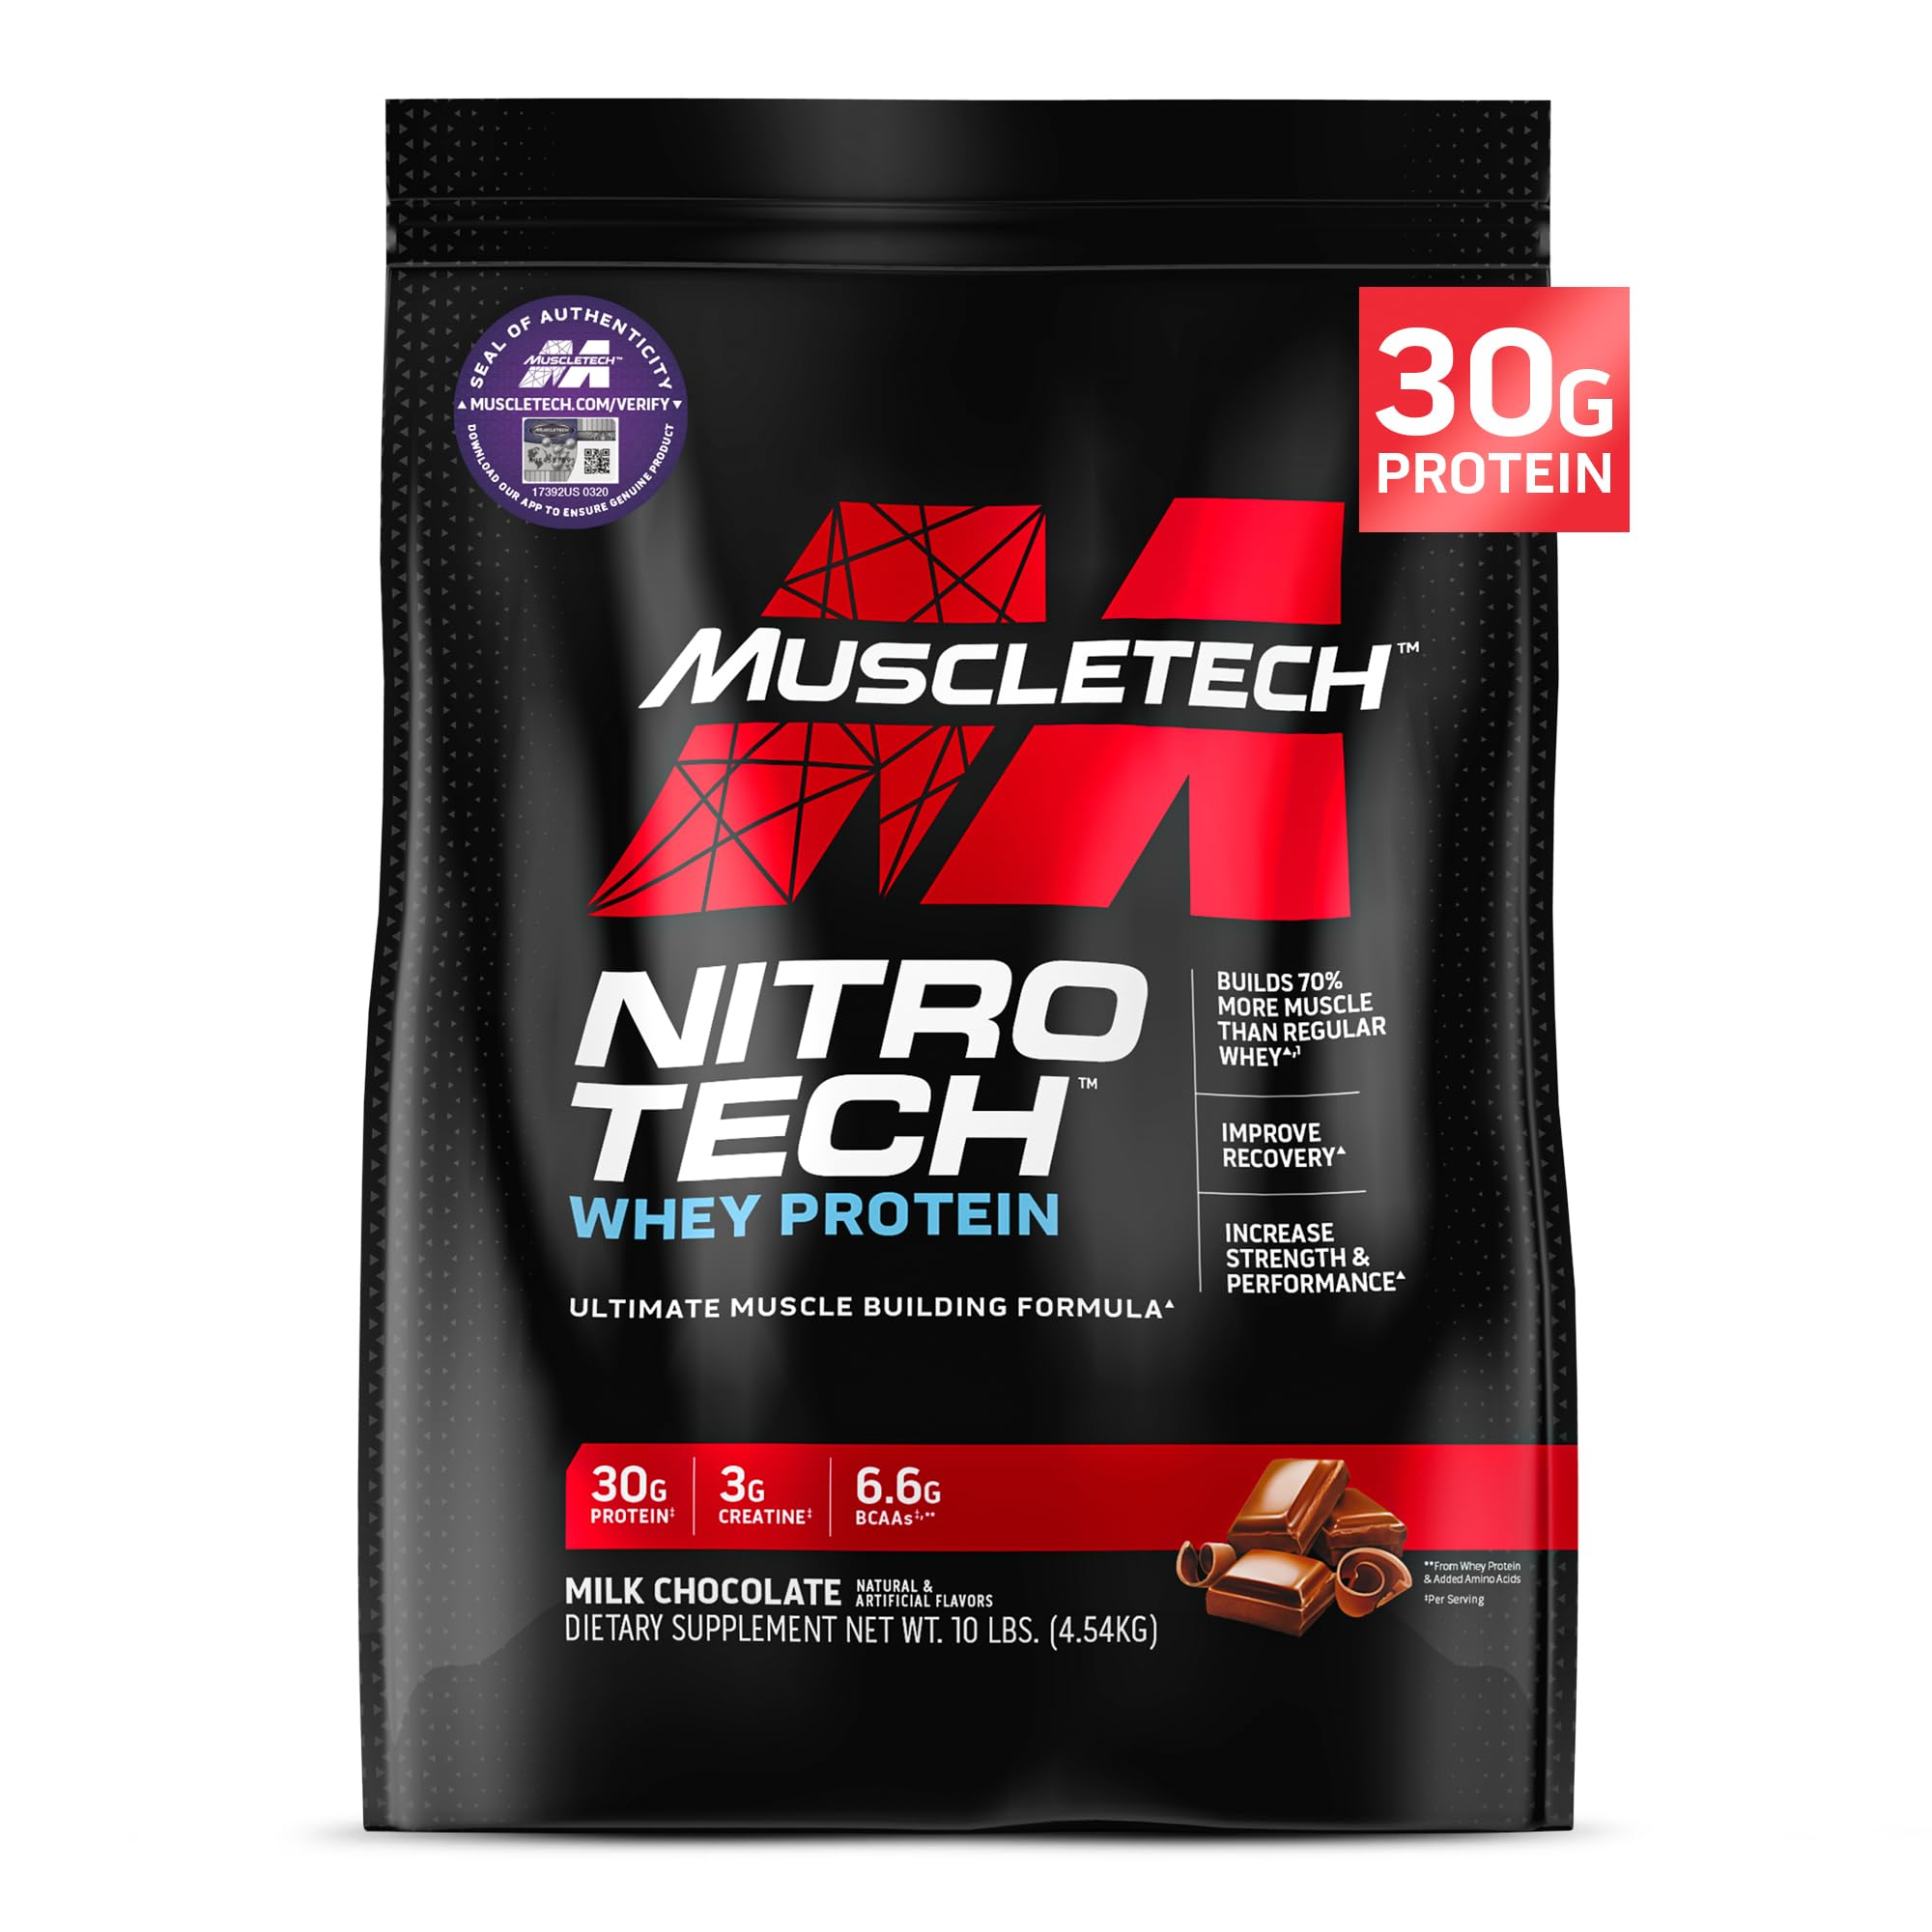

In [49]:
# Image content extraction using GPT-4o

# Add and test local image 2
image_path='../images-lab-tests/health-supplement-protein-muscletech-test-1.jpg'
data_url=local_image_to_data_url(image_path)

query="Extract all the text from the provided image and compile it into a paragraph."

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        { 
            "role": "system", 
            "content": "You are a Visual Cognitive system tasked with extracting text and information from images." 
        },
        { 
            "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": query 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": data_url                        
                    }
                }
            ] 
        } 
    ],
    #  Set a "max_tokens" value, or the return output will be cut off
    max_tokens=3000 
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")
display_image(image_path, 300, 300)

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

# Save the GPT-4o output
message=response.choices[0].message.content


In [ ]:
# RAG Hybrid (Vector and Semantic) Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

query="Find the nutritional supplement in the database that most closely \
    matches the following description and explain why: " + message

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    max_tokens=3000,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body=azureaisearch_config
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
The retrieved documents provide information about a product that closely matches the description of
Muscletech Nitro-Tech Whey Protein:

- **Product Name**: MUSCLETECH TM NITRO
- **Nutritional
Content**:
  - 30g protein per serving
  - 3g creatine per serving
  - 6.7g BCAAs per serving
-
**Purpose**: Designed to help build lean muscle, support recovery, and improve strength and
performance.
- **Flavor**: Triple Chocolate (similar to milk chocolate).
- **Packaging**: Net
weight of 1.8 kg (4.00 lbs), which does not match the 10 lbs (4.54 kg) package described.
-
**Verification**: Seal of authenticity available via muscletech.com/verify.

### Summary:
The
product described in the database matches most of the nutritional and functional aspects of the
query, including protein, creatine, and BCAA content, as well as its purpose and verification seal.
However, the packaging size (1.8 kg/4.00 lbs) differs from the 10 lbs (4.54 kg) package mentioned
in the que

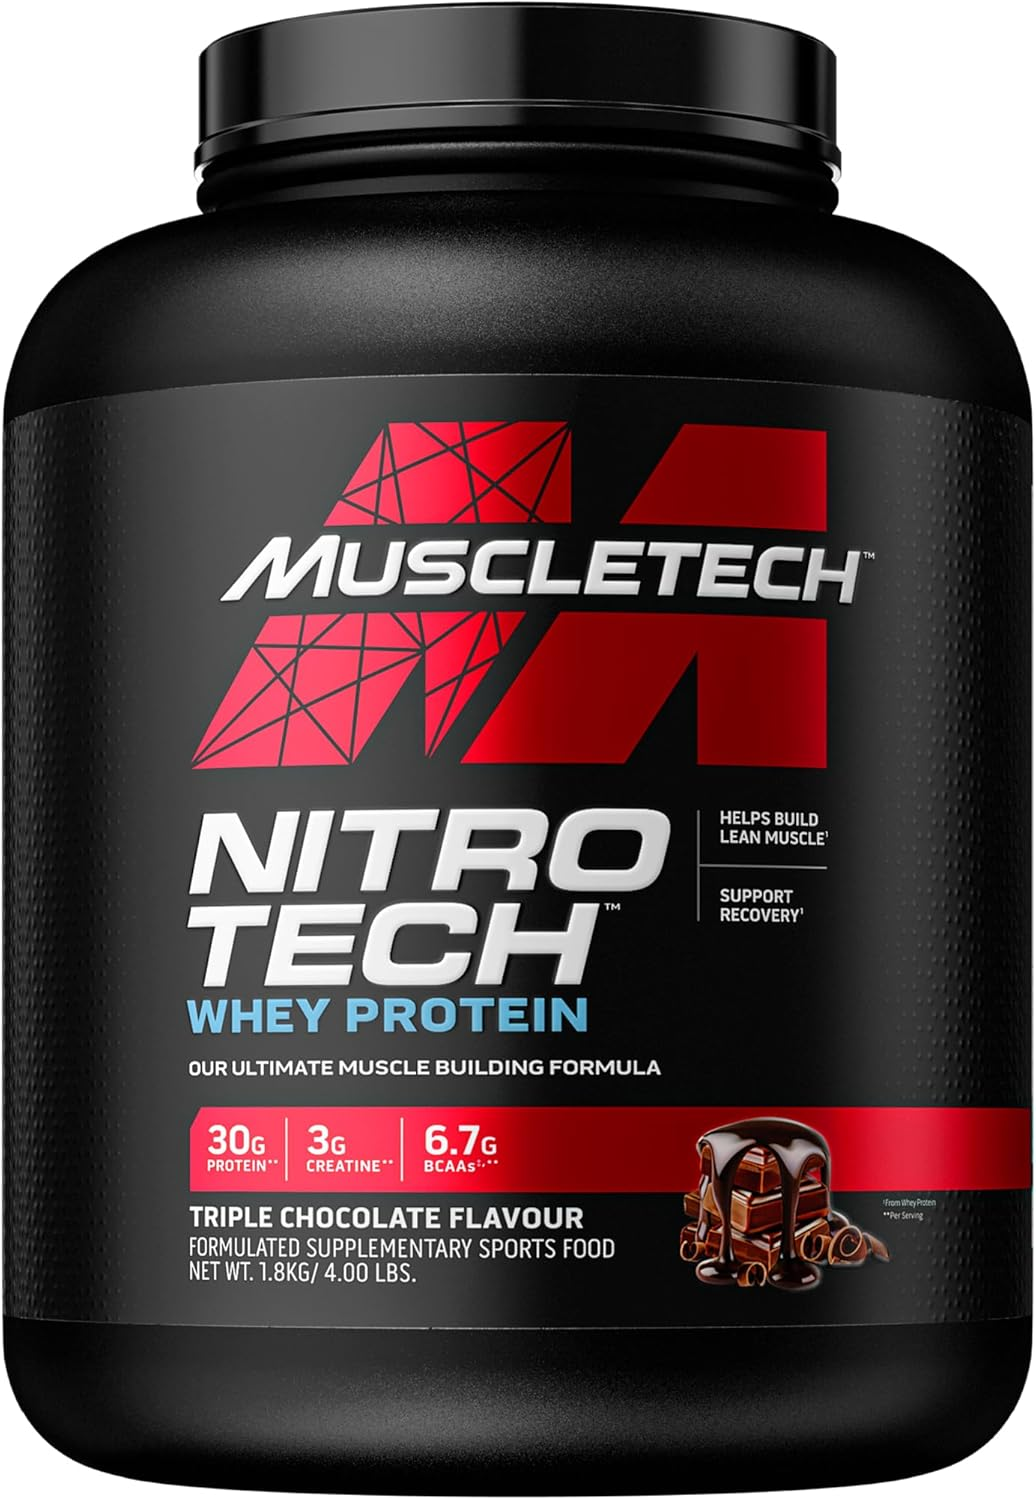

In [50]:
# Display the image
# Azure AI Search images path: "../images-aisearch/"
display_image("../images-aisearch/health-supplement-protein-muscletech-1.jpg", 200, 200)

#### Image Analysis 4

Azure OpenAI message content only:
Emergen-C, 1,000 mg Vitamin C, Daily Immune Support*, Antioxidants†, B Vitamins & Electrolytes.
Super Orange, Flavored Fizzy Drink Mix with Natural Flavors. Natural fruit flavors. Dietary
Supplement, *Vitamin C, Zinc & Manganese. 10 - 0.32 oz (9.1 g) PACKETS / NET WT. 3.2 OZ (91 g).
*These statements have not been evaluated by the Food and Drug Administration. This product is not
intended to diagnose, treat, cure, or prevent any disease.


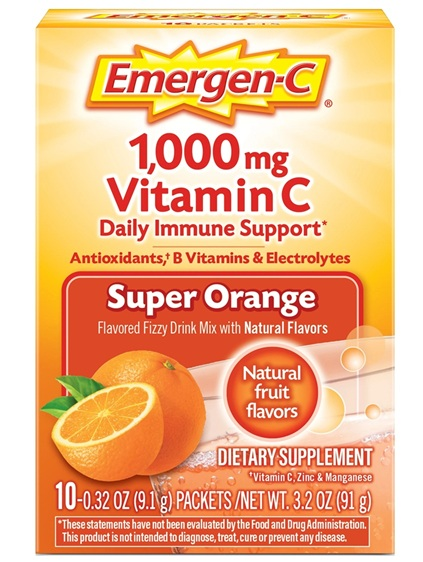

In [51]:
# Image content extraction using GPT-4o

# Add and test local image 2
image_path='../images-lab-tests/health-supplement-vitaminc-emergenc-test-1.jpg'
data_url=local_image_to_data_url(image_path)

query="Extract all the text from the provided image and compile it into a paragraph."

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        { 
            "role": "system", 
            "content": "You are a Visual Cognitive system tasked with extracting text and information from images." 
        },
        { 
            "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": query 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": data_url                        
                    }
                }
            ] 
        } 
    ],
    #  Set a "max_tokens" value, or the return output will be cut off
    max_tokens=3000 
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")
display_image(image_path, 300, 300)

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

# Save the GPT-4o output
message=response.choices[0].message.content


In [ ]:
# RAG Hybrid (Vector and Semantic) Search query from Chat GPT-4o
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

query="Find the nutritional supplement in the database that most closely \
    matches the following description and explain why: " + message

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    max_tokens=3000,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body=azureaisearch_config
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

Azure OpenAI message content only:
The nutritional supplement in the database that most closely matches the description provided is
**Emergen-C Super Orange Flavored Fizzy Drink Mix**. Here’s why:

- **Vitamin C Content**: It
contains 1,000 mg of Vitamin C, aligning with the description
[health-supplement-vitaminc-emergenc-1.jpg].
- **Daily Immune Support**: It is marketed as a
dietary supplement for immune support, featuring antioxidants and electrolytes
[health-supplement-vitaminc-emergenc-1.jpg].
- **B Vitamins and Electrolytes**: The product
includes 7 B vitamins and electrolytes, matching the specified features
[health-supplement-vitaminc-emergenc-1.jpg].
- **Flavored Fizzy Drink Mix**: It is a fizzy drink
mix with a Super Orange flavor, consistent with the description
[health-supplement-vitaminc-emergenc-1.jpg].
- **Packaging**: The product comes in packets, with a
net weight of 9.3 oz (264 g) for 30 packets, which is similar to the described packaging
[health-supplement-vitaminc

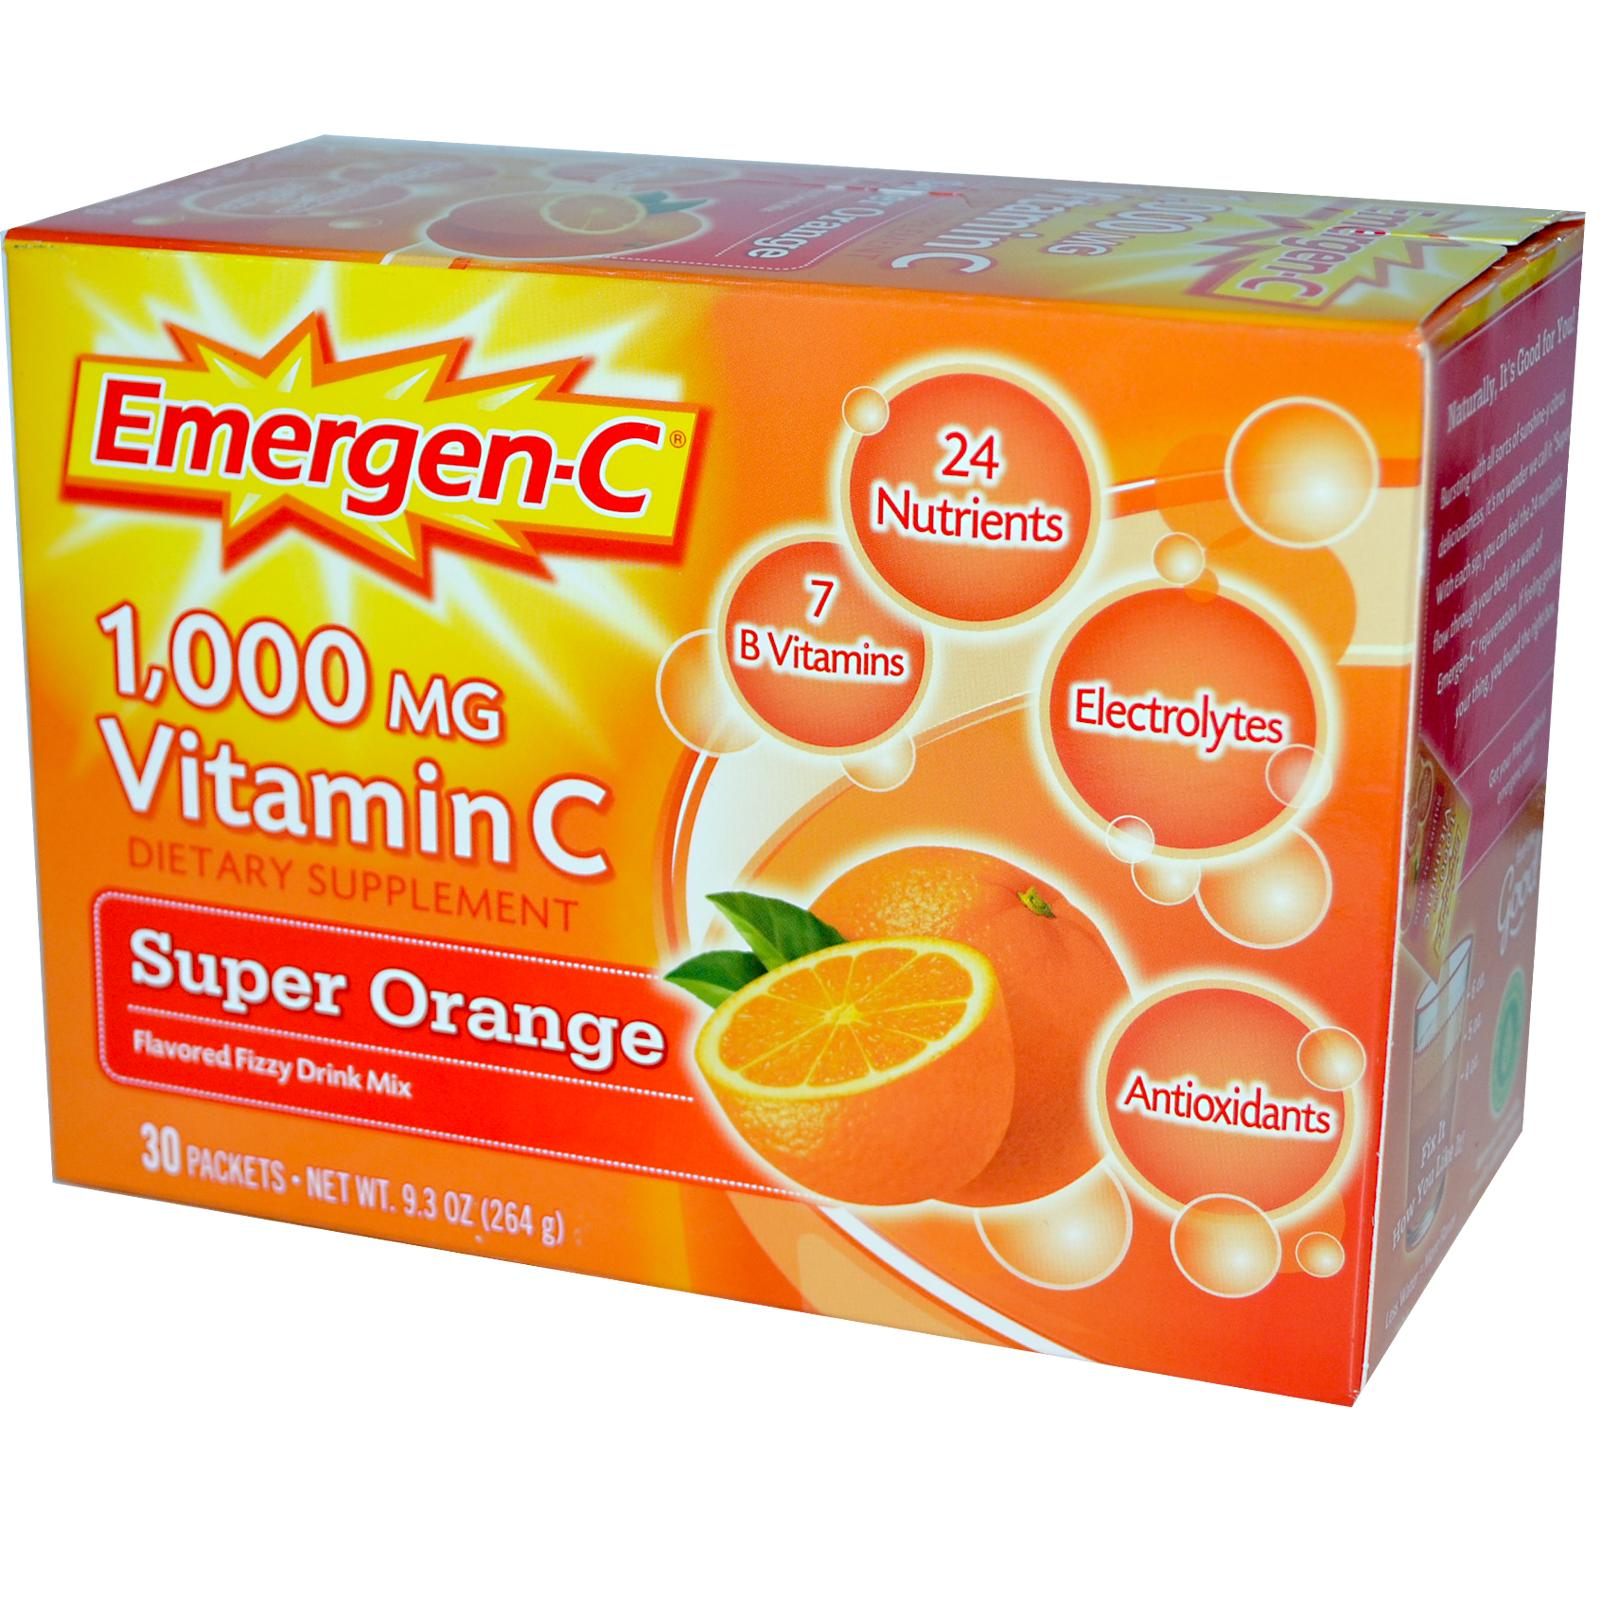

In [52]:
# Display the image
# Azure AI Search images path: "../images-aisearch/"
display_image("../images-aisearch/health-supplement-vitaminc-emergenc-1.jpg", 200, 200)

## Group Discussion

### Analyze another image

Try using an image from the [images-lab-tests](../images-lab-tests/) folder

In [ ]:
# Image content extraction using GPT-4o - Test

# Add and test local image 2
image_path='../images-lab-tests/<REPLACE_WITH_IMAGE_FILE>.jpg'
data_url=local_image_to_data_url(image_path)

query="Extract all the text from the provided image and compile it into a paragraph."

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    messages=[
        { 
            "role": "system", 
            "content": "You are a Visual Cognitive system tasked with extracting text and information from images." 
        },
        { 
            "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": query 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": data_url                        
                    }
                }
            ] 
        } 
    ],
    #  Set a "max_tokens" value, or the return output will be cut off
    max_tokens=3000 
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")
display_image(image_path,300,300)

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

# Save the GPT-4o output
message=response.choices[0].message.content


In [ ]:
# RAG Hybrid (Vector and Semantic) Search query from Chat GPT-4o - image 4
# Instructions to the model provided in variable: GROUNDED_PROMPT_AOAI

query="Find the nutritional supplement in the database that most closely \
    matches the following description and explain why: " + message

response = openai_client.chat.completions.create(
    model=azure_openai_gpt4o_name,
    max_tokens=3000,
    messages=[
        {
            "role": "user",
            "content": GROUNDED_PROMPT_AOAI.format(query=query)
        },
    ],
    extra_body=azureaisearch_config
)

print(f"Azure OpenAI message content only:\n{word_wrap(response.choices[0].message.content)}")

# Uncomment the following line if you want to see the full json response
# print(f"\nAzure OpenAI full json response:\n{response.model_dump_json(indent=2)}")

In [ ]:
# Display the image - Optional
# Azure AI Search images path: "../images-aisearch/"
display_image("../images-aisearch/health-supplement-vitaminc-emergenc-1.jpg", 200, 200)

In [ ]:
# OPTIONAL - ADD AND TEST YOUR OWN CODE IN THIS CODE BOX


In [ ]:
# OPTIONAL - ADD AND TEST YOUR OWN CODE IN THIS CODE BOX


In [ ]:
# OPTIONAL - ADD AND TEST YOUR OWN CODE IN THIS CODE BOX


### Try to answer the following questions

* What other skillsets could enrich and enhance the content of the Azure AI Search Index?
* What Azure AI Search type would you use to provide better data results to GPT-4o?
* How would you query the image_vector field?
* Which Image Service would you use extract the image content and solve the customer requirements?
* In which Azure service would you host this code?
* What others Azure Services are required to store transactional inventory data?
* Create an architecture of the solution adding features to secure and scale the Code  the system?
